# ****************** INITIALISATION DU PROGRAMME ******************

In [1]:
from datetime import datetime


#import pyodbc
import sqlalchemy
#import sqlalchemy as msql
#import Connexion_bdd as Cx_bdd
import numpy as np
import pandas as pd
import Requetes_SQL as Req_SQL
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn import feature_selection
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, KFold, RepeatedKFold, RepeatedStratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import metrics, tree

In [2]:
#Project Classes
#import FSQL_Classes as FSQLC
import Sql_Alchemy_Classes as AlSQL
import Parcours_Classes as PC
 

2023-11-07 10:26:37,446 INFO sqlalchemy.engine.Engine SELECT CAST(SERVERPROPERTY('ProductVersion') AS VARCHAR)
2023-11-07 10:26:37,447 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-11-07 10:26:37,448 INFO sqlalchemy.engine.Engine SELECT schema_name()
2023-11-07 10:26:37,449 INFO sqlalchemy.engine.Engine [generated in 0.00050s] ()
2023-11-07 10:26:37,450 INFO sqlalchemy.engine.Engine SELECT CAST('test max support' AS NVARCHAR(max))
2023-11-07 10:26:37,452 INFO sqlalchemy.engine.Engine [generated in 0.00050s] ()
2023-11-07 10:26:37,452 INFO sqlalchemy.engine.Engine SELECT TOP (10) [idUFX_Ress_Equ] FROM [ICO_Activite].[dbo].[Listing_UF_V3]
2023-11-07 10:26:37,453 INFO sqlalchemy.engine.Engine [raw sql] ()
Connexion BDD - OK


# ******    STEP 1 - GET/PREPARE THE DATA ON SQL SERVER    ********

    # Define filters parameters for a list of NIP
    # For example :
        # Tous les patients qui ont eu un acte à l'ICO le 9 septembre 2020.

## Check what's the optimal size of getting interesting data

In [1]:
#Define nb of NIP needed to have a representative dataset in nb of actes / Sejours / Sequence

from datetime import timedelta

My_filter_1rst_date=datetime.strptime('11-01-2019 00:00:00', '%m-%d-%Y %H:%M:%S')
My_filter_2nd_date=datetime.strptime('11-01-2019 00:01:00', '%m-%d-%Y %H:%M:%S')
Site='2'

Table_Compare_Datasets=[]
print('First itteration :' + str(My_filter_2nd_date))
Df_Parcours = pd.DataFrame.from_dict(PC.Caracteristiques_Dataset_Parcours(0, My_filter_1rst_date,My_filter_2nd_date,Site).get_x())

Time_Table=[1,15,30,50,75,100,125,150,175,200]
for i in Time_Table:
    My_filter_2nd_date=My_filter_2nd_date + timedelta(days=i)  
    print('\n\n Itteration nb ' + str(i+1) + ' : ' + str(My_filter_2nd_date))
    Df_Parcours=pd.concat([Df_Parcours,pd.DataFrame.from_dict(PC.Caracteristiques_Dataset_Parcours(i, My_filter_1rst_date,My_filter_2nd_date,Site).get_x())],ignore_index=True)


NameError: name 'datetime' is not defined

In [ ]:
Df_Parcours

,Name,Date1,Date2,Site,Total actes,Encoded_Actes,% Encoded_Actes,Total_sejours,Encoded_Sejours,% Encoded_Sejours,Total_sequence,Encoded_Sequence,% Encoded_Sequence,Total_NIP
0,0,2019-11-01,2019-11-01 00:01:00,2,5393,413,0.076581,509,270,0.530452,180,169,0.938889,12
1,1,2019-11-01,2019-11-02 00:01:00,2,8373,524,0.062582,916,477,0.520742,311,291,0.935691,21
2,15,2019-11-01,2019-11-17 00:01:00,2,611477,1658,0.002711,139066,23467,0.168747,40172,24913,0.620158,3517
3,30,2019-11-01,2019-12-17 00:01:00,2,986016,1925,0.001952,237263,34500,0.145408,66171,39511,0.597104,7762
4,50,2019-11-01,2020-02-05 00:01:00,2,1236731,2014,0.001628,311887,40873,0.131051,84896,49257,0.580204,11975
5,75,2019-11-01,2020-04-20 00:01:00,2,1438761,2087,0.001451,376341,46200,0.122761,101238,57371,0.566694,16213
6,100,2019-11-01,2020-07-29 00:01:00,2,1634889,2171,0.001328,437397,51024,0.116654,118465,65460,0.552568,21389
7,125,2019-11-01,2020-12-01 00:01:00,2,1819401,2238,0.001230,495592,55635,0.112260,135913,72934,0.536623,27190
8,150,2019-11-01,2021-04-30 00:01:00,2,1967378,2281,0.001159,541592,59720,0.110268,149992,78562,0.523775,32273
9,175,2019-11-01,2021-10-22 00:01:00,2,2094290,2323,0.001109,577022,63411,0.109894,161607,83376,0.515918,37271


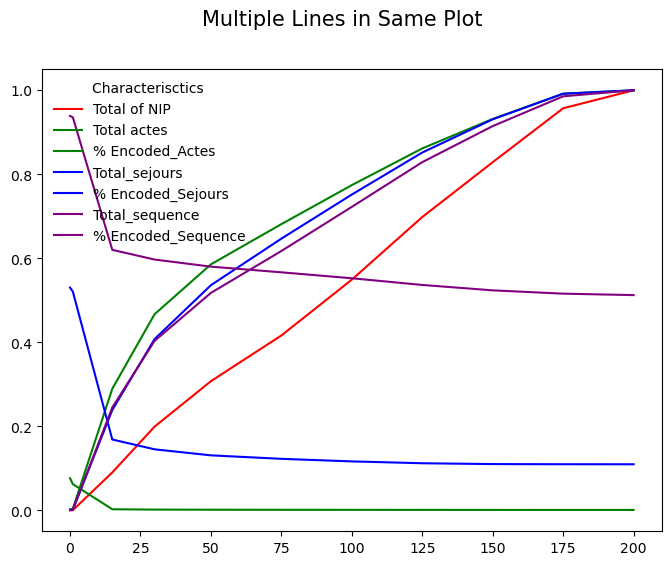

In [ ]:
#import matplotlib.pyplot as plt

# The data : Df_Parcours
x =  Df_Parcours['Name']
y1 = Df_Parcours['Total_NIP'].apply(lambda x: x/Df_Parcours['Total_NIP'].max())
y2 = Df_Parcours['Total actes'].apply(lambda x: x/Df_Parcours['Total actes'].max())
y3 = Df_Parcours['Total_sejours'].apply(lambda x: x/Df_Parcours['Total_sejours'].max())
y4 = Df_Parcours['Total_sequence'].apply(lambda x: x/Df_Parcours['Total_sequence'].max())

y2_1 = Df_Parcours['% Encoded_Actes']
y3_1 = Df_Parcours['% Encoded_Sejours']
y4_1 = Df_Parcours['% Encoded_Sequence']

# Initialise the figure and axes.
fig, ax = plt.subplots(1, figsize=(8, 6))

# Set the title for the figure
fig.suptitle('Multiple Lines in Same Plot', fontsize=15)

# Draw all the lines in the same plot, assigning a label for each one to be
# shown in the legend.
ax.plot(x, y1, color="red", label="Total of NIP")

ax.plot(x, y2, color="green", label="Total actes")
ax.plot(x, y2_1, color="green", label="% Encoded_Actes")

ax.plot(x, y3, color="blue", label="Total_sejours")
ax.plot(x, y3_1, color="blue", label="% Encoded_Sejours")

ax.plot(x, y4, color="purple", label="Total_sequence")
ax.plot(x, y4_1, color="purple", label="% Encoded_Sequence")



# Add a legend, and position it on the lower right (with no box)
plt.legend(loc="best", title="Characterisctics ", frameon=False)

plt.show()

## Optimal number of days in order to catch enought NIP, Actes, Sejours, and sequences, is around 50 days for Saint Herblain, the same for Angers. 
    ## SE TROUVE A PRESENT DISPONIBLE DANS LA BDD 
    # Listing_UF_V3
    # Tmp_A_Actes_Table_Analyse - Base de donnée d'activité filtrée par le NIP dont les colonnes sont normalisées
        # ID_A / NIP / N_S / DD_A / DF_A / DD_M / HD_M / DF_M / HF_M / UFX / INX / R_NGAP / R_CCAM / UFH / Statut / Code_Equip / Site 
    # Tmp_PS_
        # NIP / N_S / J0V1 / J0V2 / Poids_Sejour_DS / Poids_Sejour_DSOS 
    # Tmp_Type_Sequence
        # NIP / id_Seq / N_S / J0V3 / J0V4 / Type_Sequence 

# ********     STEP 2 - LOADING DATASET OF PATIENTS     **********

## Analyse des actes

### Get the data

In [5]:
from datetime import timedelta

My_NIP_filter_1rst_date=datetime.strptime('09-01-2019 00:00:00', '%m-%d-%Y %H:%M:%S')
My_NIP_filter_2nd_date=My_NIP_filter_1rst_date + timedelta(days=1)

Site='2'

Mydataset_date1=datetime.strptime('05-01-2019 00:00:00', '%m-%d-%Y %H:%M:%S')
Mydataset_date2=datetime.strptime('12-01-2019 00:00:00', '%m-%d-%Y %H:%M:%S')

Caract_Df_SH = pd.DataFrame.from_dict(PC.Caracteristiques_Dataset_Parcours(1, My_NIP_filter_1rst_date,My_NIP_filter_2nd_date,Site,Mydataset_date1,Mydataset_date2).get_x())

EXECUTE dbo.Delete_Table_if_exists Tmp_Py_A_Actes_Export
STEP 1.0 : Delete old Tables
2023-09-29 08:35:04,178 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-09-29 08:35:04,178 INFO sqlalchemy.engine.Engine EXECUTE dbo.Delete_Table_if_exists Tmp_Py_A_Actes_Export
2023-09-29 08:35:04,179 INFO sqlalchemy.engine.Engine [cached since 48.67s ago] ()
2023-09-29 08:35:04,184 INFO sqlalchemy.engine.Engine COMMIT
AlSQL_Execution - OK
STEP 1.1 : Filter NIP ON /n Site = 2/n Date1  = 2019-09-01 00:00:00 - Date2  = 2019-09-02 00:00:00 - launched at 2023-09-29 08:35:04.185687
2023-09-29 08:35:04,185 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-09-29 08:35:04,186 INFO sqlalchemy.engine.Engine  EXECUTE Preproc_A0_Filter_NIP_BY_2_DATES_AND_SITE_AND_DATASET_ON_2_DATES A_Actes_ICO_2018_2021_V2_TRIMED,Tmp_Py_A_Actes_Export,'2019-09-01 00:00:00','2019-09-02 00:00:00','2019-05-01 00:00:00','2019-12-01 00:00:00',2
2023-09-29 08:35:04,186 INFO sqlalchemy.engine.Engine [generated in 0.00046s] ()
202

In [6]:
Caract_Df_SH

,Name,Date1_filtreNIP,Date2_filtreNIP,Date3_filtre_Data_set,Date4_filtre_Data_set,Site,Total actes,Encoded_Actes,% Encoded_Actes,Total_sejours,Encoded_Sejours,% Encoded_Sejours,Total_sequence,Encoded_Sequence,% Encoded_Sequence,Total_NIP
0,1,2019-09-01,2019-09-02,2019-05-01,2019-12-01,2,48025,753,0.015679,14647,2694,0.183928,3440,2492,0.724419,690


In [18]:
#Get all actes in the Dataset

Requete = """
    SELECT Table_Enc_Actes.[ID_A]
      ,Table_Enc_Actes.[Row_Encoded]
      ,Table_Enc_Actes.[Cle_Acte_Encoded]
	  ,Table_Activite.[UFX]
	  ,Table_Activite.[UFX_CL]
	  ,CONCAT(Table_Activite.[R_NGAP],Table_Activite.[R_CCAM],Table_Activite.[UFH]) as NGAP_CCAM_UFH
	  ,CONCAT(Table_Activite.[AC_Lib],Table_Activite.CCAM_AC_Lib,Table_Activite.[UFH_L]) as NGAP_CCAM_UFH_Lib 
  FROM [ICO_Activite].[dbo].[Tmp_Acte_Encoded] as Table_Enc_Actes,
	   [ICO_Activite].[dbo].[Tmp_A_Actes_Table_Analyse] as Table_Activite
  WHERE Table_Enc_Actes.ID_A=Table_Activite.ID_A
  """

Actes_Total=AlSQL.AlSQL_Requete(AlSQL.engine,Requete,True) #FSQLC.F_SQL_Requete(FSQLC.cnxn,Requete,FSQLC.pyodbc,'No')


2023-09-29 09:52:43,764 INFO sqlalchemy.engine.Engine 
    SELECT Table_Enc_Actes.[ID_A]
      ,Table_Enc_Actes.[Row_Encoded]
      ,Table_Enc_Actes.[Cle_Acte_Encoded]
	  ,Table_Activite.[UFX]
	  ,Table_Activite.[UFX_CL]
	  ,CONCAT(Table_Activite.[R_NGAP],Table_Activite.[R_CCAM],Table_Activite.[UFH]) as NGAP_CCAM_UFH
	  ,CONCAT(Table_Activite.[AC_Lib],Table_Activite.CCAM_AC_Lib,Table_Activite.[UFH_L]) as NGAP_CCAM_UFH_Lib 
  FROM [ICO_Activite].[dbo].[Tmp_Acte_Encoded] as Table_Enc_Actes,
	   [ICO_Activite].[dbo].[Tmp_A_Actes_Table_Analyse] as Table_Activite
  WHERE Table_Enc_Actes.ID_A=Table_Activite.ID_A
  
2023-09-29 09:52:43,764 INFO sqlalchemy.engine.Engine [raw sql] ()
AlSQL_Requete - OK


In [19]:
Actes_Total

,ID_A,Row_Encoded,Cle_Acte_Encoded,UFX,UFX_CL,NGAP_CCAM_UFH,NGAP_CCAM_UFH_Lib
0,13636630,87,1933|524,1933,BIOCHIMIE GENERALE,524,LIPASEMIE (SANG)
1,13636631,68,1933|1610,1933,BIOCHIMIE GENERALE,1610,SANG : IONOGRAMME COMPLET (NA + K + CL + CO2 + P
2,13636639,85,1933|521,1933,BIOCHIMIE GENERALE,521,LACTATE DESHYDROGENASE (LDH) (SANG)
3,13636638,147,7172|AMI,7172,INF. - POSTE DE SOINS EXTERNES,AMI,AMI
4,13636641,70,1933|1806,1933,BIOCHIMIE GENERALE,1806,ALBUMINE (DOSAGE) (SANG)
...,...,...,...,...,...,...,...
48020,13894959,103,1933|7325,1933,BIOCHIMIE GENERALE,7325,ANTIGENE CA 125 (DOSAGE) (SANG)
48021,13895394,604,9050|CS,9050,CONSULTATION DE RADIOTHERAPIE,CS,CS
48022,13895395,606,9050|MCS,9050,CONSULTATION DE RADIOTHERAPIE,MCS,MCS
48023,14254561,68,1933|1610,1933,BIOCHIMIE GENERALE,1610,SANG : IONOGRAMME COMPLET (NA + K + CL + CO2 + P


### Analyse des UF

In [20]:
df_UF=Actes_Total.groupby(['UFX','UFX_CL'], group_keys=False).count().sort_values(by='Row_Encoded' , ascending=False)
df_UF['ID_A']

UFX   UFX_CL                                      
1933  BIOCHIMIE GENERALE                              16458
8920  RADIOTHERAPIE IRRADIATION                        7810
9052  CONSULTATION D'ONCOLOGIE MDICALE                4262
9018  LABORATOIRES                                     2213
1937  HEMATOCYTOLOGIE                                  1682
                                                      ...  
7176  INF - H. MD. 3ÔME HGRL                             4
7175  INF - HOSP TRADITIONNELLE DE CHIRURGIE              1
9015  RADIODIAGNOSTIC                                     1
8012  HDJ NEURO ONCO                                      1
H01   CHU ST NAZAIRE LABORATOIRE BIOLOGIE MEDICALE        1
Name: ID_A, Length: 64, dtype: int64

c:\Anaconda\envs\Parcours\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Glyph 144 (\x90) missing from current font.
  self._figure.tight_layout(*args, **kwargs)


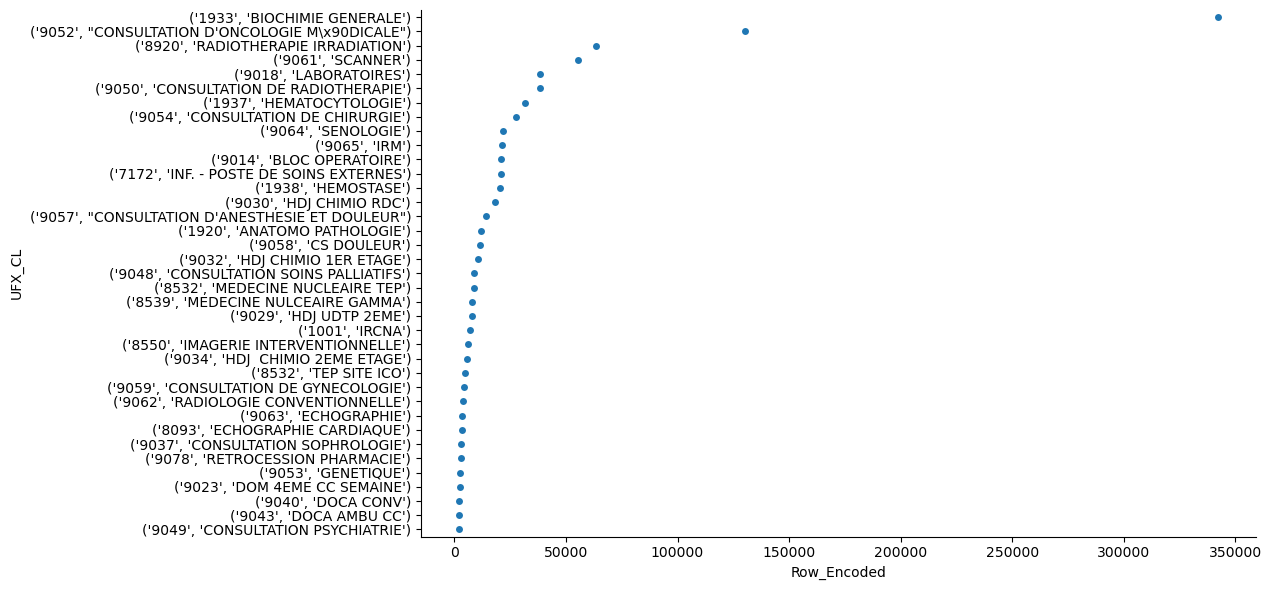

In [ ]:
cut_off=2000
plot=sns.catplot(data=df_UF[df_UF['ID_A']>cut_off], x="Row_Encoded",y="UFX_CL",height=6,aspect=2)
plot.set_yticklabels(labels=df_UF[df_UF['ID_A']>cut_off].index.to_list(), rotation=0)

### Analyse des RefCCAM / NGAP / UFH

In [ ]:
df_refCCAM_NGAP_UFH=Actes_Total.groupby(['NGAP_CCAM_UFH','NGAP_CCAM_UFH_Lib'], group_keys=False).count().sort_values(by='Row_Encoded' , ascending=False)
df_refCCAM_NGAP_UFH['ID_A']

NGAP_CCAM_UFH  NGAP_CCAM_UFH_Lib                                             
MCS            MCS                                                               86915
CS             CS                                                                84803
MPC            MPC                                                               53363
9105           FORFAIT DE SECURITE POUR ECHANTILLON SANGUIN                      38506
9005           FORFAIT DE PRISE EN CHARGE PRE-ANALYTIQUE DU PAT                  37350
                                                                                 ...  
GEPA004        trach‚o cerv.tomie                                                    1
YYYY270        imagerie pr radio/cardio interv. niveau 20 en salle imagerie          1
GEJE001        aspi th‚rap. fibro                                                    1
GAQE001        endos. cav. nasale +rhinopharynx v. nasale                            1
GLLD019        ventil. non invasive masque cumul. 2h

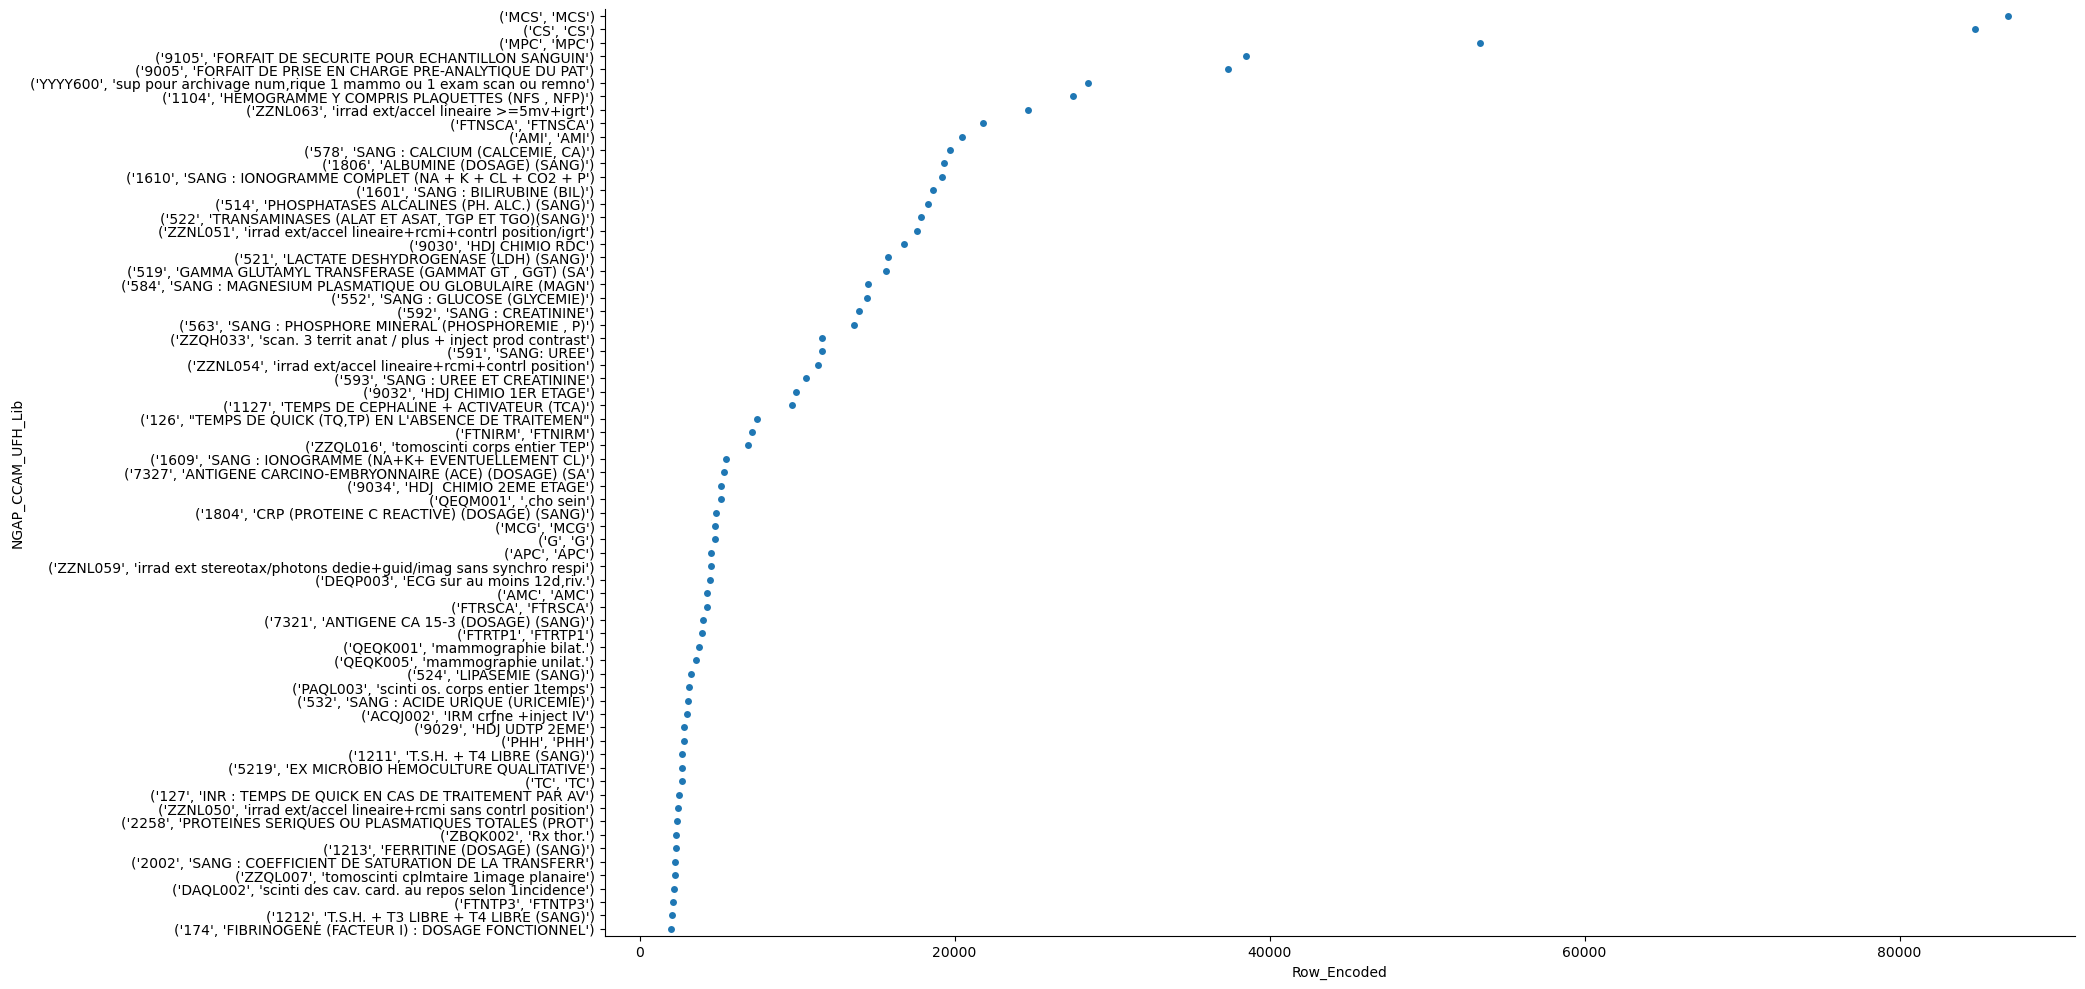

In [ ]:
cut_off=2000

plot=sns.catplot(data=df_refCCAM_NGAP_UFH[df_refCCAM_NGAP_UFH['ID_A']>cut_off], x="Row_Encoded",y="NGAP_CCAM_UFH_Lib",height=10,aspect=2)
plot.set_yticklabels(labels=df_refCCAM_NGAP_UFH[df_refCCAM_NGAP_UFH['ID_A']>cut_off].index.to_list(), rotation=0)

## Analyse des Séjours

### Get the data

In [ ]:
#Get all actes in the Dataset

Requete = """
    SELECT Table_Enc_Sejours.[N_S]
      ,Table_Enc_Sejours.[Row_Encoded]
      ,Table_Enc_Sejours.[Cle_Sejour_Encoded]
	  ,Table_Activite.[UFX] as CARAC_UFX
	  ,Table_Activite.[UFX_CL] as CARAC_UFX_CL
	  ,CONCAT(Table_Activite.[R_NGAP],Table_Activite.[R_CCAM],Table_Activite.[UFH]) as NGAP_CCAM_UFH
	  ,CONCAT(Table_Activite.[AC_Lib],Table_Activite.CCAM_AC_Lib,Table_Activite.[UFH_L]) as NGAP_CCAM_UFH 
  FROM [ICO_Activite].[dbo].[Tmp_Sejour_Encoded] as Table_Enc_Sejours,
	   [ICO_Activite].[dbo].[Tmp_A_Actes_Table_Analyse] as Table_Activite,
	   [ICO_Activite].[dbo].[Tmp_A3_Soins] as Table_act_caract_Soins --,
	   --[ICO_Activite].[dbo].[Tmp_A3_SOS] as Table_act_caract_SOS
  
  WHERE Table_act_caract_Soins.N_S=Table_Enc_Sejours.N_S AND
		Table_act_caract_Soins.Id_A_Caracteristique=Table_Activite.ID_A

  ORDER BY N_S
  """

Sejours_Total=AlSQL.F_SQL_Execute(AlSQL.engine,Requete,'No') #FSQLC.F_SQL_Requete(FSQLC.cnxn,Requete,FSQLC.pyodbc,'No')

c:\Users\vince\Documents\DSTI\DSTI_Projects\ML ICO Activity\02 - Preprocessing Data\FSQL_Classes.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)


     F_SQL_Requete - OK


In [ ]:
Sejours_Total

,N_S,Row_Encoded,Cle_Sejour_Encoded,CARAC_UFX,CARAC_UFX_CL,NGAP_CCAM_UFH,NGAP_CCAM_UFH
0,N1534903,8686,1933|514-1933|522-1933|592-1933|1212-1933|1601...,9052,CONSULTATION D'ONCOLOGIE MDICALE,CS,CS
1,N1541964,7403,1933|514-1933|519-1933|521-1933|522-1933|532-1...,1933,BIOCHIMIE GENERALE,514,PHOSPHATASES ALCALINES (PH. ALC.) (SANG)
2,N1543907,7350,1933|514-1933|519-1933|521-1933|522-1933|532-1...,1937,HEMATOCYTOLOGIE,1104,"HEMOGRAMME Y COMPRIS PLAQUETTES (NFS , NFP)"
3,N1543909,6521,1933|1806-1933|9005-1933|9105-1933|514-1933|51...,1933,BIOCHIMIE GENERALE,1806,ALBUMINE (DOSAGE) (SANG)
4,N1544004,17570,1933|593-1933|1610-1933|9005-1933|9105,1933,BIOCHIMIE GENERALE,593,SANG : UREE ET CREATININE
...,...,...,...,...,...,...,...
233339,N2347204,34748,9065|ACQJ002-9065|YYYY600-9065|FTRIRM,9065,IRM,ACQJ002,IRM crƒne +inject IV
233340,N2347208,26559,8920|ZZNL063,8920,RADIOTHERAPIE IRRADIATION,ZZNL063,irrad ext/accel lineaire >=5mv+igrt
233341,N2347254,31430,9050|MCS-9050|CS,9050,CONSULTATION DE RADIOTHERAPIE,CS,CS
233342,N2347259,33987,9061|FTRSC2-9061|FTRSC2-9061|ZZQH033-9061|YYYY600,9061,SCANNER,ZZQH033,scan. 3 territ anat / plus + inject prod contrast


In [ ]:
df_refSejours=Sejours_Total.groupby(['Cle_Sejour_Encoded'], group_keys=False).count().sort_values(by='Row_Encoded' , ascending=False)
df_refSejours

,N_S,Row_Encoded,CARAC_UFX,CARAC_UFX_CL,NGAP_CCAM_UFH,NGAP_CCAM_UFH
Cle_Sejour_Encoded,,,,,,
8920|ZZNL063,21786,21786,21786,21786,21786,21786
8920|ZZNL051,15327,15327,15327,15327,15327,15327
9030|9030,11024,11024,11024,11024,11024,11024
8920|ZZNL054,10611,10611,10611,10611,10611,10611
9052|CS-9052|MCS,9914,9914,9914,9914,9914,9914
...,...,...,...,...,...,...
1933|521-1933|532-1933|1806-1933|552-1933|578-1933|1601-1933|9105-1933|519-1933|593-1933|514-1933|584-1933|9005-1933|522-1933|524-1933|563-1933|1212-1933|7325-1933|1610-1933|1804-1937|1104-1938|1127-1938|126-7173|SE3-7173|HPJB001-9052|CS-9052|MCS-9061|YYYY600-9061|FTNSCA-9061|FTNSCA-9061|ZZQH033-9063|ZCQM008,1,1,1,1,1,1
1933|521-1933|532-1933|1806-1933|552-1933|578-1933|1601-1933|9105-1933|519-1933|593-1933|514-1933|584-1933|9005-1933|522-1933|524-1933|563-1933|1212-1933|1610-1937|1104-1938|1127-1938|126-9029|9029-9062|ZBQK002,1,1,1,1,1,1
1933|521-1933|532-1933|1806-1933|552-1933|578-1933|1601-1933|9105-1933|519-1933|593-1933|514-1933|584-1933|9005-1933|522-1933|524-1933|563-1933|1212-1933|1610-1933|1804-1937|1104-9052|AMI-9061|FTNSCA-9061|FTNSCA-9061|YYYY600-9061|ZZQH033,1,1,1,1,1,1


### Analyse des differents groupes de séjours

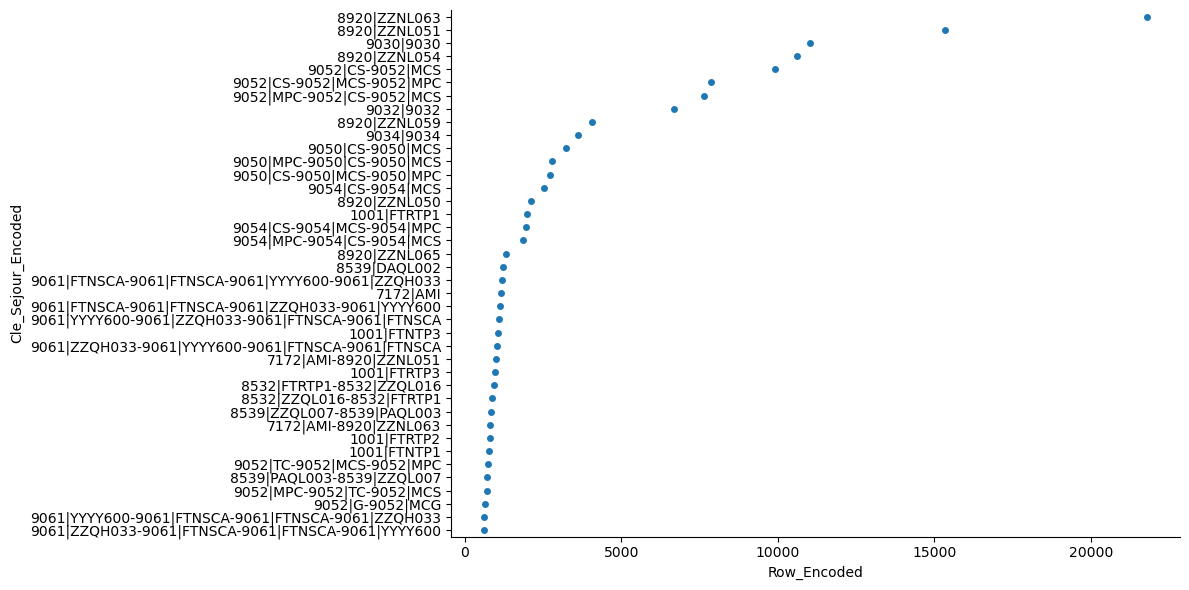

In [ ]:
cut_off=600
plot=sns.catplot(data=df_refSejours[df_refSejours['N_S']>cut_off], x="Row_Encoded",y="Cle_Sejour_Encoded",height=6,aspect=2)
plot.set_yticklabels(labels=df_refSejours[df_refSejours['N_S']>cut_off].index.to_list(), rotation=0)

In [ ]:
# RECUPERATION DES LIBELLES DES ACTES CARACTERISTIQUES
df_uf_caract_sej=pd.DataFrame(df_refSejours.head(20).index)
df_uf_caract_sej['Len']= [len(i.split("-")) for i in df_uf_caract_sej.Cle_Sejour_Encoded]

j=df_uf_caract_sej['Len'].max()

for k in range(j):
    df_uf_caract_sej['Acte' + str(k+1)]= [i.split("-")[k] if len(i.split("-"))>k else '' for i in df_uf_caract_sej.Cle_Sejour_Encoded]
    df_uf_caract_sej['Acte' + str(k+1) + '-UF']=[i.split("|")[0] if len(i.split("|"))>0 else ''for i in df_uf_caract_sej['Acte' + str(k+1)]]
    df_uf_caract_sej['Acte' + str(k+1) + '-Ref']=[i.split("|")[1] if len(i.split("|"))>1 else '' for i in df_uf_caract_sej['Acte' + str(k+1)]]
    df_uf_caract_sej['Acte' + str(k+1) + '-UF-Name']=[FSQLC.F_SQL_Requete(FSQLC.cnxn,'SELECT DISTINCT [UFX_CL] FROM [ICO_Activite].[dbo].[Tmp_A_Actes_Table_Analyse] WHERE [Tmp_A_Actes_Table_Analyse].UFX=\''+ i + '\'',FSQLC.pyodbc).UFX_CL[0] if i!='' else '' for i in df_uf_caract_sej['Acte' + str(k+1) + '-UF']]
    df_uf_caract_sej['Acte' + str(k+1) + '-Ref-Name']=[FSQLC.F_SQL_Requete(FSQLC.cnxn,'SELECT DISTINCT CONCAT([AC_Lib],[CCAM_AC_Lib],[UFH_L]) as Ref FROM [ICO_Activite].[dbo].[Tmp_A_Actes_Table_Analyse]  WHERE CONCAT([R_NGAP],[R_CCAM],[UFH])=\''+ i + '\'',FSQLC.pyodbc).Ref[0] if i!='' else '' for i in df_uf_caract_sej['Acte' + str(k+1) + '-Ref']]


"SELECT DISTINCT [UFX_CL] FROM [ICO_Activite].[dbo].[Tmp_A_Actes_Table_Analyse] WHERE [Tmp_A_Actes_Table_Analyse].UFX='8920'"
"SELECT DISTINCT CONCAT([AC_Lib],[CCAM_AC_Lib],[UFH_L])  FROM [ICO_Activite].[dbo].[Tmp_A_Actes_Table_Analyse]  WHERE CONCAT([R_NGAP],[R_CCAM],[UFH])='9030'"


#df_uf_caract_sej['Acte1']= [i.split("-")[0] for i in df_uf_caract_sej.Cle_Sejour_Encoded]
#df_uf_caract_sej['Acte2']= [i.split("-")[1] if len(i.split("-"))>1 else '' for i in df_uf_caract_sej.Cle_Sejour_Encoded]
#df_uf_caract_sej['Acte3']= [i.split("-")[2] if len(i.split("-"))>2 else '' for i in df_uf_caract_sej.Cle_Sejour_Encoded]

#df_uf_caract_sej

#0 if i == 1 else 1 

c:\Users\vince\Documents\DSTI\DSTI_Projects\ML ICO Activity\02 - Preprocessing Data\FSQL_Classes.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
c:\Users\vince\Documents\DSTI\DSTI_Projects\ML ICO Activity\02 - Preprocessing Data\FSQL_Classes.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)
c:\Users\vince\Documents\DSTI\DSTI_Projects\ML ICO Activity\02 - Preprocessing Data\FSQL_Classes.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.re

"SELECT DISTINCT CONCAT([AC_Lib],[CCAM_AC_Lib],[UFH_L])  FROM [ICO_Activite].[dbo].[Tmp_A_Actes_Table_Analyse]  WHERE CONCAT([R_NGAP],[R_CCAM],[UFH])='9030'"

In [ ]:
df_uf_caract_sej

,Cle_Sejour_Encoded,Len,Acte1,Acte1-UF,Acte1-Ref,Acte1-UF-Name,Acte1-Ref-Name,Acte2,Acte2-UF,Acte2-Ref,Acte2-UF-Name,Acte2-Ref-Name,Acte3,Acte3-UF,Acte3-Ref,Acte3-UF-Name,Acte3-Ref-Name
0,8920|ZZNL063,1,8920|ZZNL063,8920,ZZNL063,RADIOTHERAPIE IRRADIATION,irrad ext/accel lineaire >=5mv+igrt,,,,,,,,,,
1,8920|ZZNL051,1,8920|ZZNL051,8920,ZZNL051,RADIOTHERAPIE IRRADIATION,irrad ext/accel lineaire+rcmi+contrl position/...,,,,,,,,,,
2,9030|9030,1,9030|9030,9030,9030,HDJ CHIMIO RDC,HDJ CHIMIO RDC,,,,,,,,,,
3,8920|ZZNL054,1,8920|ZZNL054,8920,ZZNL054,RADIOTHERAPIE IRRADIATION,irrad ext/accel lineaire+rcmi+contrl position,,,,,,,,,,
4,9052|CS-9052|MCS,2,9052|CS,9052,CS,CONSULTATION D'ONCOLOGIE MDICALE,CS,9052|MCS,9052,MCS,CONSULTATION D'ONCOLOGIE MDICALE,MCS,,,,,
5,9052|CS-9052|MCS-9052|MPC,3,9052|CS,9052,CS,CONSULTATION D'ONCOLOGIE MDICALE,CS,9052|MCS,9052,MCS,CONSULTATION D'ONCOLOGIE MDICALE,MCS,9052|MPC,9052,MPC,CONSULTATION D'ONCOLOGIE MDICALE,MPC
6,9052|MPC-9052|CS-9052|MCS,3,9052|MPC,9052,MPC,CONSULTATION D'ONCOLOGIE MDICALE,MPC,9052|CS,9052,CS,CONSULTATION D'ONCOLOGIE MDICALE,CS,9052|MCS,9052,MCS,CONSULTATION D'ONCOLOGIE MDICALE,MCS
7,9032|9032,1,9032|9032,9032,9032,HDJ CHIMIO 1ER ETAGE,HDJ CHIMIO 1ER ETAGE,,,,,,,,,,
8,8920|ZZNL059,1,8920|ZZNL059,8920,ZZNL059,RADIOTHERAPIE IRRADIATION,irrad ext stereotax/photons dedie+guid/imag sa...,,,,,,,,,,
9,9034|9034,1,9034|9034,9034,9034,HDJ CHIMIO 2EME ETAGE,HDJ CHIMIO 2EME ETAGE,,,,,,,,,,


In [ ]:

df_uf_caract_sej[['Acte1-UF-Name','Acte1-Ref-Name','Acte2-UF-Name','Acte2-Ref-Name','Acte3-UF-Name','Acte3-Ref-Name']]

,Acte1-UF-Name,Acte1-Ref-Name,Acte2-UF-Name,Acte2-Ref-Name,Acte3-UF-Name,Acte3-Ref-Name
0,RADIOTHERAPIE IRRADIATION,irrad ext/accel lineaire >=5mv+igrt,,,,
1,RADIOTHERAPIE IRRADIATION,irrad ext/accel lineaire+rcmi+contrl position/...,,,,
2,HDJ CHIMIO RDC,HDJ CHIMIO RDC,,,,
3,RADIOTHERAPIE IRRADIATION,irrad ext/accel lineaire+rcmi+contrl position,,,,
4,CONSULTATION D'ONCOLOGIE MDICALE,CS,CONSULTATION D'ONCOLOGIE MDICALE,MCS,,
5,CONSULTATION D'ONCOLOGIE MDICALE,CS,CONSULTATION D'ONCOLOGIE MDICALE,MCS,CONSULTATION D'ONCOLOGIE MDICALE,MPC
6,CONSULTATION D'ONCOLOGIE MDICALE,MPC,CONSULTATION D'ONCOLOGIE MDICALE,CS,CONSULTATION D'ONCOLOGIE MDICALE,MCS
7,HDJ CHIMIO 1ER ETAGE,HDJ CHIMIO 1ER ETAGE,,,,
8,RADIOTHERAPIE IRRADIATION,irrad ext stereotax/photons dedie+guid/imag sa...,,,,
9,HDJ CHIMIO 2EME ETAGE,HDJ CHIMIO 2EME ETAGE,,,,


In [ ]:
#FSQLC.F_SQL_Requete(FSQLC.cnxn,"SELECT DISTINCT [UFX_CL] FROM [ICO_Activite].[dbo].[Tmp_A_Actes_Table_Analyse] WHERE [Tmp_A_Actes_Table_Analyse].UFX='8920'",FSQLC.pyodbc,'No').UFX_CL[0]

AlSQL.F_SQL_Execute(AlSQL.engine,"SELECT DISTINCT [UFX_CL] FROM [ICO_Activite].[dbo].[Tmp_A_Actes_Table_Analyse] WHERE [Tmp_A_Actes_Table_Analyse].UFX='8920'",'No').UFX_CL[0]

     F_SQL_Requete - OK


c:\Users\vince\Documents\DSTI\DSTI_Projects\ML ICO Activity\02 - Preprocessing Data\FSQL_Classes.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)


'RADIOTHERAPIE IRRADIATION'

### Analyse des UF caracteristiques de séjour (par dimension de soins)

In [ ]:
df_sej_UF=Sejours_Total.groupby(['CARAC_UFX','CARAC_UFX_CL'], group_keys=False).count().sort_values(by='Row_Encoded' , ascending=False)
df_sej_UF

,,N_S,Row_Encoded,Cle_Sejour_Encoded,NGAP_CCAM_UFH,NGAP_CCAM_UFH
CARAC_UFX,CARAC_UFX_CL,,,,,
8920,RADIOTHERAPIE IRRADIATION,62343,62343,62343,62343,62343
9052,CONSULTATION D'ONCOLOGIE MDICALE,44929,44929,44929,44929,44929
9030,HDJ CHIMIO RDC,17130,17130,17130,17130,17130
9050,CONSULTATION DE RADIOTHERAPIE,13702,13702,13702,13702,13702
9054,CONSULTATION DE CHIRURGIE,10737,10737,10737,10737,10737
...,...,...,...,...,...,...
1934,BIOCHIMIE SPECIALISEE,2,2,2,2,2
9051,CONSULTATION DE MEDECINE NUCLEAIRE,1,1,1,1,1
8910,RADIOTHERAPIE PREPARATION,1,1,1,1,1


c:\Anaconda\envs\Parcours\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Glyph 144 (\x90) missing from current font.
  self._figure.tight_layout(*args, **kwargs)


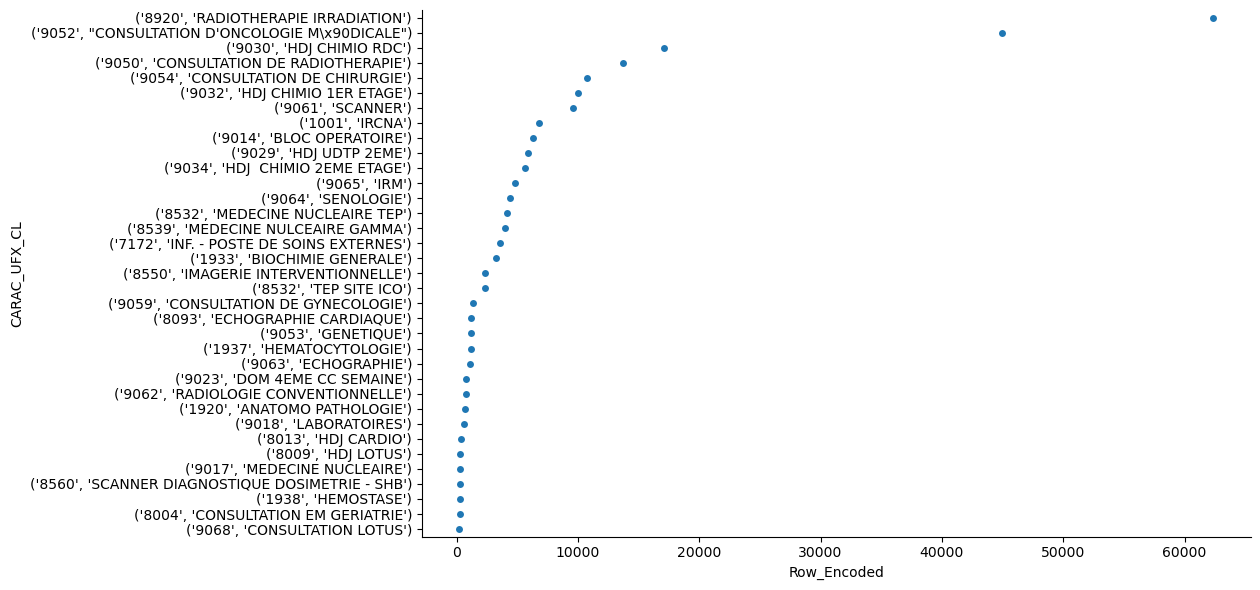

In [ ]:
cut_off=200
plot=sns.catplot(data=df_sej_UF[df_sej_UF['N_S']>cut_off], x="Row_Encoded",y="CARAC_UFX_CL",height=6,aspect=2)
plot.set_yticklabels(labels=df_sej_UF[df_sej_UF['N_S']>cut_off].index.to_list(), rotation=0)

In [ ]:
df_sej_UF=Sejours_Total.groupby(['CARAC_UFX','CARAC_UFX_CL'], group_keys=False).count().sort_values(by='Row_Encoded' , ascending=False)
df_sej_UF

,,N_S,Row_Encoded,Cle_Sejour_Encoded,NGAP_CCAM_UFH,NGAP_CCAM_UFH
CARAC_UFX,CARAC_UFX_CL,,,,,
8920,RADIOTHERAPIE IRRADIATION,62343,62343,62343,62343,62343
9052,CONSULTATION D'ONCOLOGIE MDICALE,44929,44929,44929,44929,44929
9030,HDJ CHIMIO RDC,17130,17130,17130,17130,17130
9050,CONSULTATION DE RADIOTHERAPIE,13702,13702,13702,13702,13702
9054,CONSULTATION DE CHIRURGIE,10737,10737,10737,10737,10737
...,...,...,...,...,...,...
1934,BIOCHIMIE SPECIALISEE,2,2,2,2,2
9051,CONSULTATION DE MEDECINE NUCLEAIRE,1,1,1,1,1
8910,RADIOTHERAPIE PREPARATION,1,1,1,1,1


### Analyse des RefCCAM / NGAP / UFH

In [ ]:
df_refCCAM_NGAP_UFH=Actes_Total.groupby(['NGAP_CCAM_UFH','NGAP_CCAM_UFH_Lib'], group_keys=False).count().sort_values(by='Row_Encoded' , ascending=False)
df_refCCAM_NGAP_UFH

,,ID_A,Row_Encoded,Cle_Acte_Encoded,UFX,UFX_CL
NGAP_CCAM_UFH,NGAP_CCAM_UFH_Lib,,,,,
MCS,MCS,86915,86915,86915,86915,86915
CS,CS,84803,84803,84803,84803,84803
MPC,MPC,53363,53363,53363,53363,53363
9105,FORFAIT DE SECURITE POUR ECHANTILLON SANGUIN,38506,38506,38506,38506,38506
9005,FORFAIT DE PRISE EN CHARGE PRE-ANALYTIQUE DU PAT,37350,37350,37350,37350,37350
...,...,...,...,...,...,...
GEPA004,trach‚o cerv.tomie,1,1,1,1,1
YYYY270,imagerie pr radio/cardio interv. niveau 20 en salle imagerie,1,1,1,1,1
GEJE001,aspi th‚rap. fibro,1,1,1,1,1


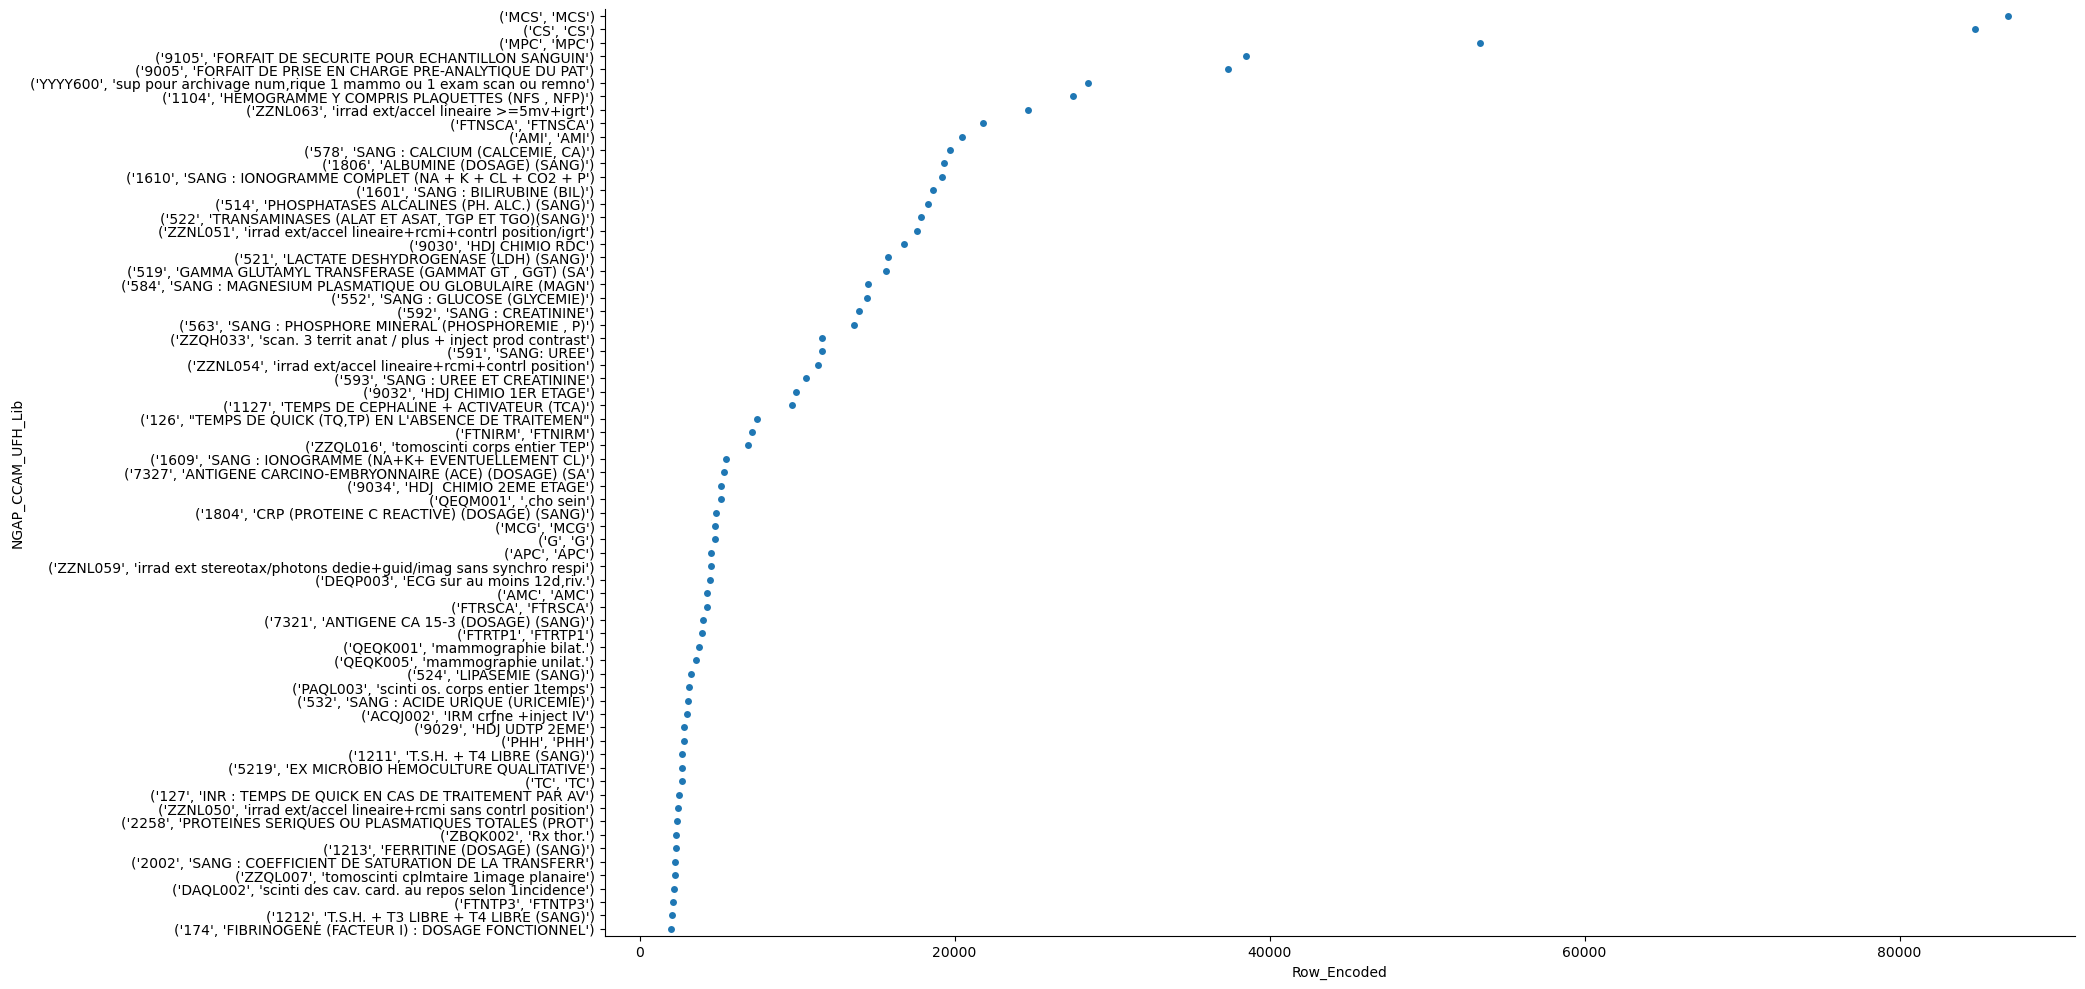

In [ ]:
cut_off=2000

plot=sns.catplot(data=df_refCCAM_NGAP_UFH[df_refCCAM_NGAP_UFH['ID_A']>cut_off], x="Row_Encoded",y="NGAP_CCAM_UFH_Lib",height=10,aspect=2)
plot.set_yticklabels(labels=df_refCCAM_NGAP_UFH[df_refCCAM_NGAP_UFH['ID_A']>cut_off].index.to_list(), rotation=0)

## Analyse des Séquences

### Get the data

In [ ]:
#Get all actes in the Dataset

Requete = """
SELECT	Table_Sequence_Encoded.[Row_Encoded],
		Table_Sequence_Encoded.[Cle_Sequence_Encoded]

  FROM [ICO_Activite].[dbo].[Tmp_Sequence_Encoded] as Table_Sequence_Encoded
  """

Sequences_Total=FSQLC.F_SQL_Requete(FSQLC.cnxn,Requete,FSQLC.pyodbc,'No')

     F_SQL_Requete - OK


c:\Users\vince\Documents\DSTI\DSTI_Projects\ML ICO Activity\02 - Preprocessing Data\FSQL_Classes.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(requete_sql, cnxn)


In [ ]:
Sequences_Total

,Row_Encoded,Cle_Sequence_Encoded
0,9840,24361
1,20391,30027-30162-29743-29743
2,42,10065
3,35941,34840-34908
4,31608,33595-33595
...,...,...
67381,14237,26559-26559-26559-26559-26559
67382,6877,21346-30027
67383,8702,23325-34772-34907-7185
67384,9682,24180-33335-34314-32565-34704-31806-33861-3180...


In [ ]:
df_refSequences=Sequences_Total.groupby(['Cle_Sequence_Encoded'], group_keys=False).count().sort_values(by='Row_Encoded' , ascending=False)
df_refSequences

,Row_Encoded
Cle_Sequence_Encoded,
29743,1178
31754,1102
32565,1079
31806,1056
31053,720
...,...
26402-26402-26402-26402-26402-26402-26402-26402-26402-26402-26402-26402-26402-26402-26402-26402-26402-26402-26402-26402-26402-26402-26402-26402-26402-26402-26402-26468-26402-26402-26402,1
26402-26402-26402-26402-26402-26402-26402-26402-26402-26402-26402-26402-26402-26402-26402-26402-26402-26402-26402-26402-26402-26402-26402-26402-26402-26402-26559-22734-26559-23023-26559-23023-18441-23023,1
26402-26402-26402-26402-26402-26402-26402-26402-26402-26402-26402-26402-26402-26402-26402-26402-26402-26402-26402-26402-26402-26402-26402-26402-26402-26402-26559-23023-26559-26559-26559-26559-26559-26559,1


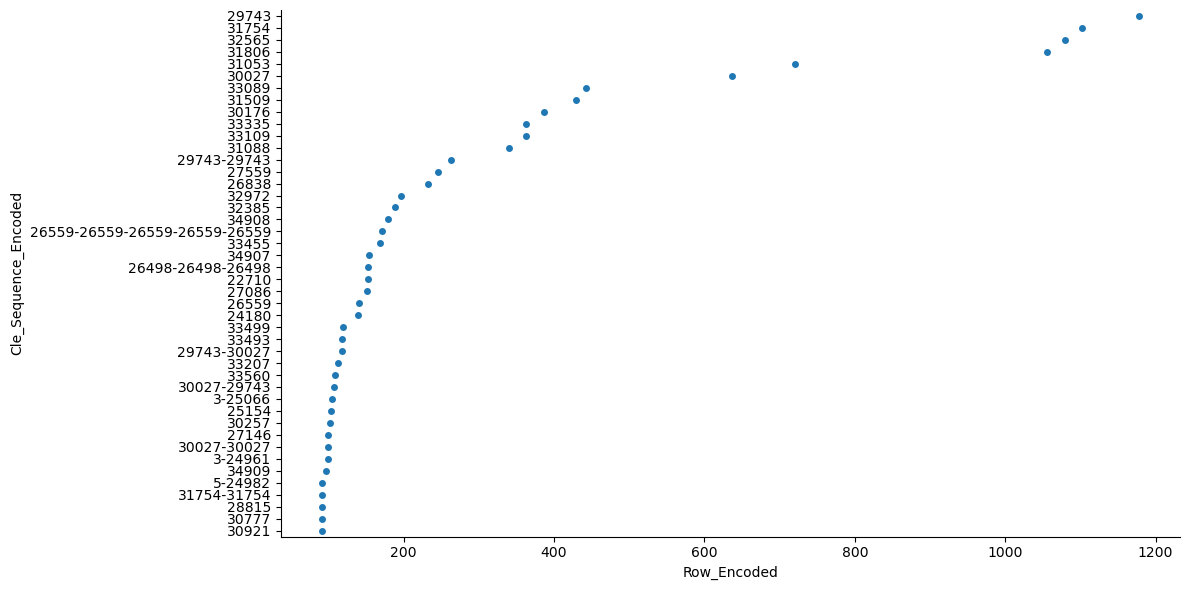

In [ ]:
cut_off=90
plot=sns.catplot(data=df_refSequences[df_refSequences['Row_Encoded']>cut_off], x="Row_Encoded",y="Cle_Sequence_Encoded",height=6,aspect=2)
plot.set_yticklabels(labels=df_refSequences[df_refSequences['Row_Encoded']>cut_off].index.to_list(), rotation=0)

In [ ]:
df_sej_carac_seq=pd.DataFrame(df_refSequences.head(20).index)
df_sej_carac_seq['Len']= [len(i.split("-")) for i in df_sej_carac_seq.Cle_Sequence_Encoded]

j=df_sej_carac_seq['Len'].max()

for k in range(j):
    df_sej_carac_seq['Sejour' + str(k+1)] = [i.split("-")[k] if len(i.split("-"))>k else '' for i in df_sej_carac_seq.Cle_Sequence_Encoded]

df_sej_carac_seq

,Cle_Sequence_Encoded,Len,Sejour1,Sejour2,Sejour3,Sejour4,Sejour5
0,29743,1,29743,,,,
1,31754,1,31754,,,,
2,32565,1,32565,,,,
3,31806,1,31806,,,,
4,31053,1,31053,,,,
5,30027,1,30027,,,,
6,33089,1,33089,,,,
7,31509,1,31509,,,,
8,30176,1,30176,,,,
9,33335,1,33335,,,,


## Analyse des Parcours


In [1]:
from datetime import datetime


#import pyodbc
import sqlalchemy
#import sqlalchemy as msql
#import Connexion_bdd as Cx_bdd
import numpy as np
import pandas as pd
import Requetes_SQL as Req_SQL
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn import feature_selection
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, KFold, RepeatedKFold, RepeatedStratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import metrics, tree

In [2]:
#Project Classes
#import FSQL_Classes as FSQLC
import Sql_Alchemy_Classes as AlSQL
import Parcours_Classes as PC
 

Connexion BDD - OK


### CLUSTER BY CLE_ENCODE_PARCOURS (EQUIVALENT TO A LIST OF SEJOURS)

In [21]:
#Erase all temporary tables in the database
PC.Caracteristiques_Dataset_Parcours.restart_DB()

NameError: name 'self' is not defined

In [3]:
#Reduce number of NIP and actes to be able to plot some graphes (changing)

from datetime import timedelta

Date1_Filter_NIP=datetime.strptime('01-01-2018 00:00:00', '%m-%d-%Y %H:%M:%S')
Date2_Filter_NIP=Date1_Filter_NIP + timedelta(days=40)  

Date1_Etude=datetime.strptime('01-01-2018 00:00:00', '%m-%d-%Y %H:%M:%S')
Date2_Etude=datetime.strptime('12-31-2019 00:00:00', '%m-%d-%Y %H:%M:%S')

Site='2'


Caract_Df_SH = pd.DataFrame.from_dict(PC.Caracteristiques_Dataset_Parcours(40, Date1_Filter_NIP,Date2_Filter_NIP,Site,Date1_Etude,Date2_Etude).get_x())

EXECUTE dbo.Delete_Table_if_exists Tmp_Py_A_Actes_Export
STEP 1.0 : Delete old Tables
2023-07-31 17:23:59,612 INFO sqlalchemy.engine.Engine SELECT CAST(SERVERPROPERTY('ProductVersion') AS VARCHAR)
2023-07-31 17:23:59,613 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-07-31 17:23:59,614 INFO sqlalchemy.engine.Engine SELECT schema_name()
2023-07-31 17:23:59,614 INFO sqlalchemy.engine.Engine [generated in 0.00039s] ()
2023-07-31 17:23:59,616 INFO sqlalchemy.engine.Engine SELECT CAST('test max support' AS NVARCHAR(max))
2023-07-31 17:23:59,616 INFO sqlalchemy.engine.Engine [generated in 0.00047s] ()
2023-07-31 17:23:59,617 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-07-31 17:23:59,618 INFO sqlalchemy.engine.Engine EXECUTE dbo.Delete_Table_if_exists Tmp_Py_A_Actes_Export
2023-07-31 17:23:59,618 INFO sqlalchemy.engine.Engine [generated in 0.00044s] ()
2023-07-31 17:23:59,620 INFO sqlalchemy.engine.Engine COMMIT
AlSQL_Execution - OK
STEP 1.1 : Filter NIP ON /n Site = 2/n Date1  = 201

In [13]:
Caract_Df_SH

,Name,Date1,Date2,Site,Total actes,Encoded_Actes,% Encoded_Actes,Total_sejours,Encoded_Sejours,% Encoded_Sejours,Total_sequence,Encoded_Sequence,% Encoded_Sequence,Total_NIP
0,40,2018-01-01,2018-02-10,2,410873,1443,0.003512,96909,18383,0.189693,25579,16148,0.631299,6440


In [14]:
Requete = """
SELECT *
  FROM [ICO_Activite].[dbo].[Tmp_Group_Carac_Parcours]
  """
Parcours_Encoded_Total=AlSQL.AlSQL_Requete(AlSQL.engine,Requete,'No')

2023-07-31 17:27:05,410 INFO sqlalchemy.engine.Engine 
SELECT *
  FROM [ICO_Activite].[dbo].[Tmp_Group_Carac_Parcours]
  
2023-07-31 17:27:05,410 INFO sqlalchemy.engine.Engine [raw sql] ()
AlSQL_Requete - OK


In [15]:
Parcours_Encoded_Total

,NIP,Cle_Encode_Parcours,J_Parcours_V1,J_Parcours_V3,J_DataSet,Duree,Activite_?,Activite_Acte infirmier,Activite_Ambulatoire,Activite_APA,...,Service_Laboratoire,Service_Médecine Nucléaire,Service_Oncologie Medicale,Service_Orl,Service_Pharmacie,Service_Prestation Exterieure,Service_Radio Interventionnelle,Service_Radiothérapie,Service_Soins de Support,Service_UDTP
0,N201504861,8922-8922-8922-11574-11574-11574-11574-11574-1...,0,951,36,308,0,0,0,0,...,5,0,12,0,0,0,0,0,4,0
1,N201101451,12087-12087-12087-9836-9836-9836,0,2392,16,562,0,0,0,0,...,0,0,4,0,0,0,0,0,0,0
2,N201304622,10134-6692-6692-6692,0,1666,21,593,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0
3,N201800855,2733,0,0,38,1,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
4,N200906224,10573-10573-10638-10638-10638-10638-10638-1063...,0,3129,23,659,0,0,0,0,...,0,0,0,0,0,0,0,0,26,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6435,N201600155,2861-7494-7494-7494-7494-7494-7494-7494-7494-7...,0,585,36,486,0,0,0,0,...,0,4,14,0,0,0,2,2,2,0
6436,N201603465,1738-1738-1738-1738-1738-6278,0,566,17,85,0,0,0,0,...,20,0,10,0,0,0,0,2,2,0
6437,N201703395,8969-8969-8969-16077-16077-16077-16077-16077,0,194,10,614,0,0,0,0,...,17,0,11,0,0,0,0,0,0,0
6438,N201800661,1720,0,0,30,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
Parcours_Encoded_Total=Parcours_Encoded_Total[Parcours_Encoded_Total['NIP'].str.startswith('N2018')]

In [40]:
X2_encoded=Parcours_Encoded_Total.copy()
X2_encoded=X2_encoded.drop('NIP',axis=1)
X2_encoded=X2_encoded.drop('Cle_Encode_Parcours',axis=1)

In [21]:
#LABEL ENCODING COLONNE CLE_ENCODE_PARCOURS

#Cas de mots séparés entre "-"
X1=Parcours_Encoded_Total['Cle_Encode_Parcours'].str.split("-")

X1_encoded = pd.get_dummies(pd.DataFrame(X1.tolist()).stack()).groupby(level=0).sum()
# Remplacer les valeurs supérieures à 1 par 1 pour indiquer la présence
X1_encoded = X1_encoded.clip(upper=1)

# Afficher le résultat de l'encodage catégoriel
print("Encodage catégoriel :")
print(X1_encoded)

Encodage catégoriel :
      1  10  100  1000  10000  10001  10002  10003  10004  10005  ...  9990  \
0     0   0    0     0      0      0      0      0      0      0  ...     0   
1     0   0    0     0      0      0      0      0      0      0  ...     0   
2     0   0    0     0      0      0      0      0      0      0  ...     0   
3     0   0    0     0      0      0      0      0      0      0  ...     0   
4     0   0    0     0      0      0      0      0      0      0  ...     0   
...  ..  ..  ...   ...    ...    ...    ...    ...    ...    ...  ...   ...   
6435  0   0    0     0      0      0      0      0      0      0  ...     0   
6436  0   0    0     0      0      0      0      0      0      0  ...     0   
6437  0   0    0     0      0      0      0      0      0      0  ...     0   
6438  0   0    0     0      0      0      0      0      0      0  ...     0   
6439  0   0    0     0      0      0      0      0      0      0  ...     0   

      9991  9992  9993  9994 

In [19]:
#Cas de données numériques séparés entre "-"
X1=Parcours_Encoded_Total['Cle_Encode_Parcours'].str.split("-")

# Convertir la liste de listes en un dataframe avec chaque mot dans une colonne
X1_encoded = pd.DataFrame(X1.tolist(), index=Parcours_Encoded_Total.index)
X1_encoded.fillna(0, inplace=True)
print(X1_encoded)

        0      1      2      3      4      5      6      7      8      9    \
0      8922   8922   8922  11574  11574  11574  11574  11574  11574  11574   
1     12087  12087  12087   9836   9836   9836      0      0      0      0   
2     10134   6692   6692   6692      0      0      0      0      0      0   
3      2733      0      0      0      0      0      0      0      0      0   
4     10573  10573  10638  10638  10638  10638  10638  10638  10638  10638   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
6435   2861   7494   7494   7494   7494   7494   7494   7494   7494   7494   
6436   1738   1738   1738   1738   1738   6278      0      0      0      0   
6437   8969   8969   8969  16077  16077  16077  16077  16077      0      0   
6438   1720      0      0      0      0      0      0      0      0      0   
6439   9703  10763  10763      0      0      0      0      0      0      0   

      ... 125 126 127 128 129 130 131 132 133 134  
0     ...  

In [41]:
#X_df = pd.concat([X1_encoded, X2_encoded], axis=1)
X_df = X2_encoded

# Standardiser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_df)

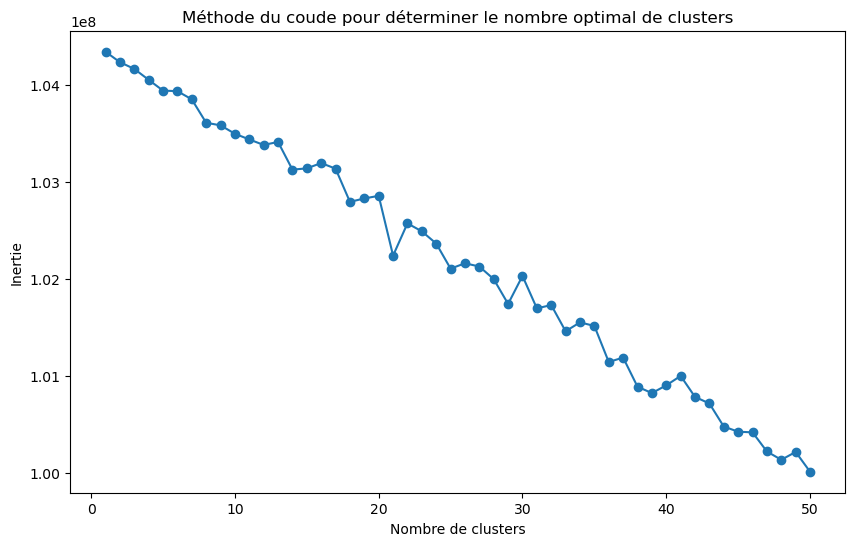

In [23]:
#CLUSTERING K MEANS


from sklearn.cluster import KMeans

# Liste pour stocker les valeurs de l'inertie
inertia = []

# Nombre de clusters que vous souhaitez tester
max_clusters = 50

for n_clusters in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Tracer le graphique de l'inertie en fonction du nombre de clusters
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters + 1), inertia, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.title('Méthode du coude pour déterminer le nombre optimal de clusters')
plt.show()

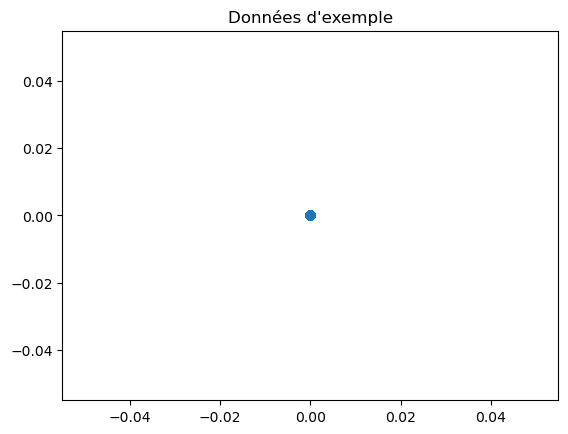

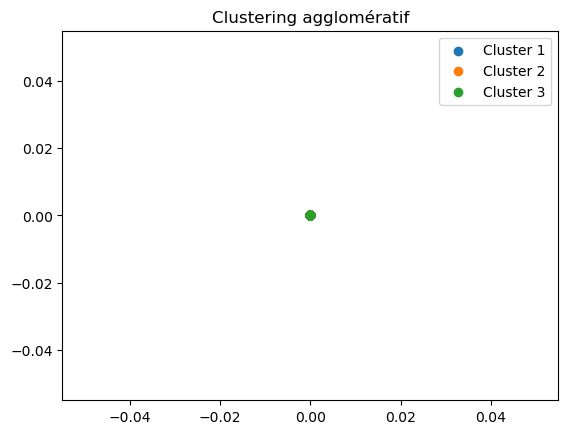

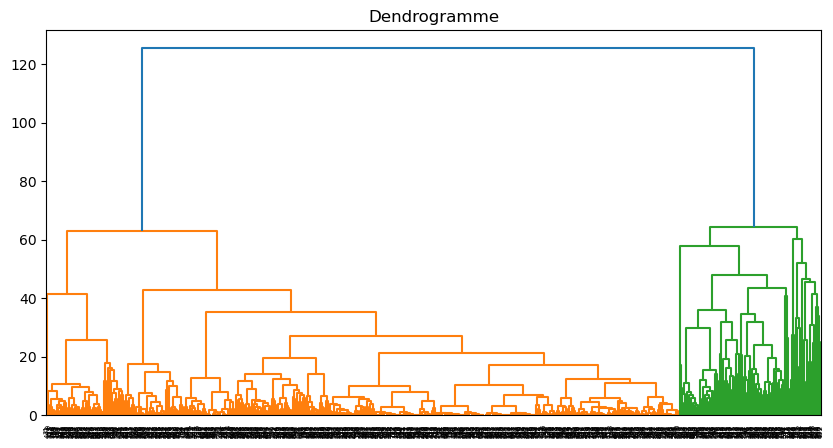

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Génération de données aléatoires pour l'exemple
#X, y = make_blobs(n_samples=100, centers=3, random_state=42)

X=X_scaled


# Affichage des données
plt.scatter(X[:, 0], X[:, 1])
plt.title("Données d'exemple")
plt.show()

# Clustering agglomératif avec scikit-learn
# Utilisation de linkage 'ward' pour minimiser la variance des distances entre clusters fusionnés.
agglomerative_clustering = AgglomerativeClustering(n_clusters=10, linkage='ward')
labels = agglomerative_clustering.fit_predict(X)

# Affichage des clusters obtenus
plt.scatter(X[labels == 0, 0], X[labels == 0, 1], label='Cluster 1')
plt.scatter(X[labels == 1, 0], X[labels == 1, 1], label='Cluster 2')
plt.scatter(X[labels == 2, 0], X[labels == 2, 1], label='Cluster 3')
plt.title("Clustering agglomératif")
plt.legend()
plt.show()

# Affichage du dendrogramme
# Ceci vous permettra de visualiser les étapes de la fusion des clusters.
Z = linkage(X, method='ward')
plt.figure(figsize=(10, 5))
dendrogram(Z)
plt.title("Dendrogramme")
plt.show()

In [35]:
#CLUSTERING AGGLOMERATIF

import pandas as pd
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

# Charger vos données (remplacez "votre_dataframe" par votre DataFrame)
data = X_scaled

# Choisissez le nombre de clusters que vous souhaitez obtenir
nombre_clusters = 3

# Appliquer le clustering hiérarchique agglomératif
clustering = AgglomerativeClustering(n_clusters=nombre_clusters)
clusters = clustering.fit_predict(data)

# Convertir le tableau NumPy en DataFrame avec une colonne 'Cluster'
data['Cluster'] = clusters

# Afficher les statistiques des clusters (par exemple, la moyenne de chaque colonne par cluster)
cluster_stats = data.groupby('Cluster').mean()
print("Statistiques des clusters:")
print(cluster_stats)

# Visualisation (pour 2 premières colonnes, adaptez selon vos dimensions)
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=clusters, cmap='rainbow')
plt.title('Clustering hiérarchique agglomératif')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [18]:
# Appliquer le clustering k-means

from sklearn.cluster import KMeans

n_clusters = 7  # Choisissez le nombre de clusters souhaité
kmeans = KMeans(n_clusters=n_clusters)
labels = kmeans.fit_predict(X_scaled)

Parcours_Encoded_Total['Cluster']=labels


In [19]:
# Calculer le nombre de NIP dans chaque cluster
df_X_values = Parcours_Encoded_Total['Cluster'].value_counts()

# Ajouter une colonne "X_abscisse" au DataFrame Parcours_Encoded_Total pour stocker les abscisses calculées
Parcours_Encoded_Total['X_abscisse'] = None

# Calculer la largeur de chaque segment pour les abscisses
abscisse_segment_width = 100 / n_clusters

# Initialiser un dictionnaire pour suivre l'indice à l'intérieur de chaque groupe
indices_dans_groupe = {}

# Calculer l'abscisse pour chaque NIP en fonction de l'indice du cluster et de la largeur du segment
for index, row in Parcours_Encoded_Total.iterrows():
    cluster = row['Cluster']
    n_nip = df_X_values[cluster]
    
    # Vérifier si le cluster est déjà dans le dictionnaire
    if cluster not in indices_dans_groupe:
        indices_dans_groupe[cluster] = 0
    
    # Calculer l'abscisse en fonction de l'indice du groupe et de la largeur du segment
    abscisse = 1.5*cluster + indices_dans_groupe[cluster] / n_nip
    Parcours_Encoded_Total.at[index, 'X_abscisse'] = abscisse * abscisse_segment_width
    
    # Incrémenter l'indice dans le groupe
    indices_dans_groupe[cluster] += 1

# Afficher le DataFrame avec les abscisses calculées
print(Parcours_Encoded_Total[['NIP', 'Cluster', 'X_abscisse']])


#Sauvegarder dans la BDD l'association NIP - Cluster
Table_Cluster='Tmp_NIP_Cluster' 
Requete = 'EXECUTE dbo.Delete_Table_if_exists ' + Table_Cluster
with AlSQL.engine.begin() as conn:
            conn.execute(sqlalchemy.text(Requete))

Parcours_Encoded_Total[['NIP','Cluster','X_abscisse']].to_sql(Table_Cluster,AlSQL.engine)


#Recuperer une table acte avec les clusters
Requete="""SELECT Table_Acte.[NIP]
	  ,Table_Cluster.Cluster
	  ,Table_Cluster.X_abscisse
      ,Table_Acte.[J_Parcours_V3]
      ,Table_Acte.[Service]
      ,Table_Acte.[Activite]
      ,Table_Acte.[Phase]
      ,Table_Acte.[Dimension]
      ,Table_Acte.[Type_seq]
  FROM [ICO_Activite].[dbo].[Tmp_Carac_Actes] as Table_Acte
	 , [ICO_Activite].[dbo].[Tmp_NIP_Cluster] as Table_Cluster
  
  WHERE Table_Cluster.NIP = Table_Acte.NIP
"""
df_Actes_graph=AlSQL.AlSQL_Requete(AlSQL.engine,Requete,'No')

             NIP  Cluster X_abscisse
0     N201606983        2  42.857143
1     N201600383        2  42.858855
2     N201504365        2  42.860567
3     N201603652        2   42.86228
4     N201702388        2  42.863992
...          ...      ...        ...
8344  N201604014        2  57.134296
8345  N200803771        2  57.136008
8346  N201301603        2   57.13772
8347  N201800920        2  57.139433
8348  N201600763        2  57.141145

[8349 rows x 3 columns]
2023-07-31 17:20:14,659 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-07-31 17:20:14,665 INFO sqlalchemy.engine.Engine EXECUTE dbo.Delete_Table_if_exists Tmp_NIP_Cluster
2023-07-31 17:20:14,665 INFO sqlalchemy.engine.Engine [generated in 0.00592s] ()
2023-07-31 17:20:14,675 INFO sqlalchemy.engine.Engine COMMIT
2023-07-31 17:20:14,685 INFO sqlalchemy.engine.Engine SELECT [INFORMATION_SCHEMA].[TABLES].[TABLE_NAME], [INFORMATION_SCHEMA].[TABLES].[TABLE_TYPE] 
FROM [INFORMATION_SCHEMA].[TABLES] 
WHERE [INFORMATION_SCHEMA].[

<Axes: title={'center': 'Carepathes'}, xlabel='X_abscisse', ylabel='J_Parcours_V3'>

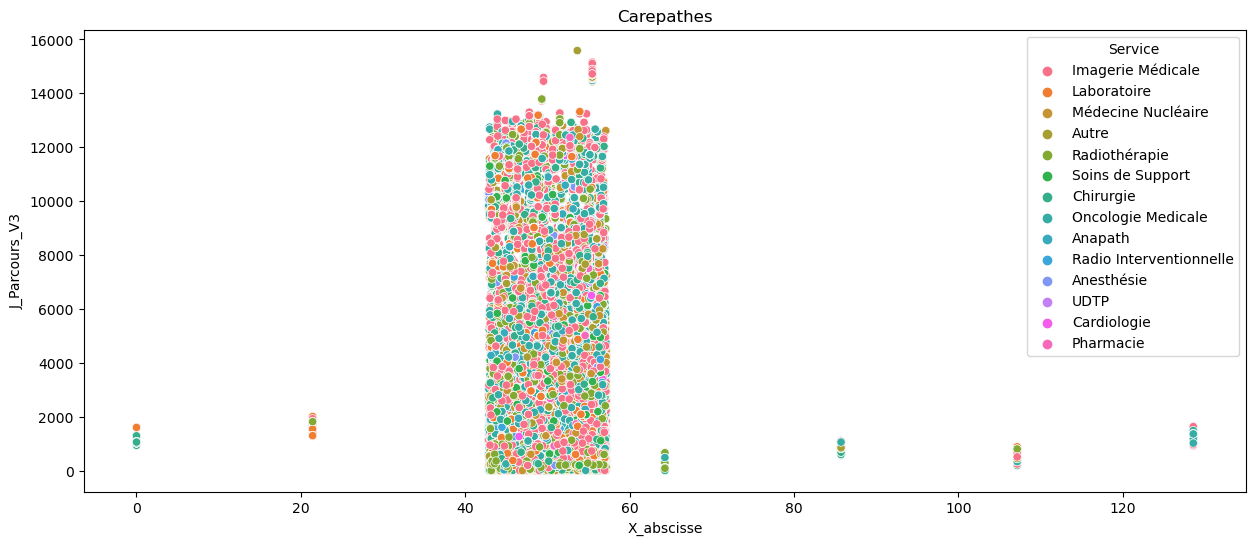

In [20]:
fig, axs = plt.subplots(1, 1, figsize=(15, 6))

data_graph=df_Actes_graph

axs.set_title('Carepathes')
sns.scatterplot(data=df_Actes_graph, x=df_Actes_graph.X_abscisse, y='J_Parcours_V3',markers='Activite', hue='Service')
#axs.flat[1].set_title('ratings_count boxplot')
#sns.boxplot(data=df, x='ratings_count', ax=axs[1])

### CLUSTER BY CLE_ENCODE_PARCOURS (EQUIVALENT TO A LIST OF SEJOURS) + POIDS ACTES / SEJOURS / SEQUENCES / PARCOURS

In [ ]:
#Get all actes in the Dataset With J_ParcoursV1 and description of UF (Service / Ativité)

Requete = """
SELECT 
	   Table_acte_sejours.[NIP]
	  --,'0' as Type_Parcours 
	  ,Table_acte_sejours.[N_S]
	  ,Table_acte_sejours.[ID_A]
      ,Table_acte_sejours.[DD_A]
	  ,Table_acte_sejours.[DF_A]
	  ,Table_PS.J0_V1 as J0_V1
	  ,Table_Seq_NS.J0_V3 as J0_V3
	  ,DATEDIFF(D,Table_PS.J0_V1,Table_acte_sejours.[DD_A]) as J_Parcours_V1
	  ,DATEDIFF(D,Table_PS.J0_V2,Table_acte_sejours.[DD_A]) as J_Parcours_V2
	  ,DATEDIFF(D,Table_Seq_NS.J0_V3,Table_acte_sejours.[DD_A]) as J_Parcours_V3
	  ,DATEDIFF(D,'Jan  1 2018 12:00AM',Table_acte_sejours.[DD_A]) as J_DataSet
	  ,DATEDIFF(D,Table_acte_sejours.[DD_A],Table_acte_sejours.[DF_A])+1 as Duree
	  ,Table_UF.Service as Service
	  ,Table_UF.Activite as Activite
 
 FROM  [ICO_Activite].[dbo].[Tmp_A_Actes_Table_Analyse] as Table_acte_sejours,
	   [ICO_Activite].[dbo].[Tmp_Type_Sequence] as Table_Seq_NS,
	   [ICO_Activite].[dbo].[Listing_UF_V3] as Table_UF,
	   [ICO_Activite].[dbo].[Tmp_PS_] as Table_PS

 WHERE  Table_acte_sejours.N_S=Table_PS.N_S AND
		Table_acte_sejours.N_S=Table_Seq_NS.N_S AND
		Table_UF.UFX_Code=Table_acte_sejours.UFX
  """
Parcours_Actes_Total=FSQLC.F_SQL_Requete(FSQLC.cnxn,Requete,FSQLC.pyodbc,'No')

     F_SQL_Requete - OK


In [ ]:
Parcours_Actes_Total.columns

Index(['NIP', 'N_S', 'ID_A', 'DD_A', 'DF_A', 'J0_V1', 'J0_V3', 'J_Parcours_V1',
       'J_Parcours_V2', 'J_Parcours_V3', 'J_DataSet', 'Duree', 'Service',
       'Activite'],
      dtype='object')

In [ ]:
Parcours_Actes_Total

,NIP,N_S,ID_A,DD_A,DF_A,J0_V1,J0_V3,J_Parcours_V1,J_Parcours_V2,J_Parcours_V3,J_DataSet,Duree,Service,Activite
0,N200703521,N1689198,662712,2018-07-06,2018-07-06,2018-01-23,2007-07-01,164,-193,4023,186,1,Imagerie Médicale,Radio
1,N201407466,N1683375,662730,2018-06-26,2018-06-26,2018-03-13,2014-07-01,105,-13,1456,176,1,Imagerie Médicale,Senologie
2,N201803723,N1687552,662741,2018-07-04,2018-07-04,2018-06-28,2018-06-28,6,-8,6,184,1,Médecine Nucléaire,Scintigraphie
3,N201802519,N1709394,662750,2018-08-22,2018-08-22,2018-04-26,2018-04-26,118,68,118,233,1,Imagerie Médicale,Echographie
4,N201800525,N1623141,662769,2018-02-20,2018-02-20,2018-01-25,2018-01-25,26,-2,26,50,1,Imagerie Médicale,IRM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215896,N201903250,N1949390,733641,2019-12-16,2019-12-16,2019-05-20,2019-05-20,210,203,210,714,1,Radiothérapie,Traitement
215897,N201902156,N1876894,648759,2019-07-25,2019-07-25,2019-04-03,2019-04-03,113,93,113,570,1,Radiothérapie,Traitement
215898,N201904507,N1910634,648989,2019-10-02,2019-10-02,2019-07-10,2019-07-10,84,57,84,639,1,Imagerie Médicale,Radio
215899,N201703699,N1649531,649487,2018-04-13,2018-04-13,2018-01-19,2017-07-01,84,31,286,102,1,Radiothérapie,Traitement


In [ ]:
Parcours_Actes_Total.Service.value_counts()

Laboratoire                99065
Oncologie Medicale         36278
Radiothérapie              23246
Imagerie Médicale          20135
Chirurgie                  10157
Soins de Support            6353
Autre                       5173
Médecine Nucléaire          4874
Anesthésie                  2999
Anapath                     2589
UDTP                        1761
Radio Interventionnelle     1675
Cardiologie                  834
Pharmacie                    748
HDJ                           13
Prestation Exterieure          1
Name: Service, dtype: int64

In [ ]:
Parcours_Actes_Filtre=Parcours_Actes_Total[(Parcours_Actes_Total['Service']=='Radiothérapie') | (Parcours_Actes_Total['Service']=='Chirurgie') | (Parcours_Actes_Total['Service']=='Oncologie Medicale')]
Parcours_Actes_Filtre

,NIP,N_S,ID_A,DD_A,DF_A,J0_V1,J0_V3,J_Parcours_V1,J_Parcours_V2,J_Parcours_V3,J_DataSet,Duree,Service,Activite,Cluster,Clus-NIP
5,N200906492,N1638991,662781,2018-03-23,2018-03-23,2018-01-30,2009-07-01,52,30,3187,81,1,Radiothérapie,Traitement,7,7-N200906492
6,N201803581,N1698947,662791,2018-08-03,2018-08-03,2018-06-20,2018-06-20,44,0,44,214,1,Chirurgie,Bloc Opératoire,7,7-N201803581
12,N201705252,N1680651,662954,2018-06-19,2018-06-19,2018-02-02,2017-07-01,137,25,353,169,1,Radiothérapie,Traitement,6,6-N201705252
13,N201004616,N1628755,662996,2018-03-02,2018-03-02,2018-01-16,2010-07-01,45,45,2801,60,1,Radiothérapie,Traitement,6,6-N201004616
16,N200000062,N1673884,663038,2018-06-06,2018-06-06,2018-01-08,2000-07-01,149,132,6549,156,1,Chirurgie,Bloc Opératoire,6,6-N200000062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215894,N201806313,N1894873,733387,2019-09-04,2019-09-04,2018-11-06,2018-11-06,302,75,302,611,1,Radiothérapie,Traitement,10,10-N201806313
215895,N201905344,N1907988,733448,2019-09-27,2019-09-27,2019-08-19,2019-08-19,39,4,39,634,1,Radiothérapie,Traitement,6,6-N201905344
215896,N201903250,N1949390,733641,2019-12-16,2019-12-16,2019-05-20,2019-05-20,210,203,210,714,1,Radiothérapie,Traitement,15,15-N201903250
215897,N201902156,N1876894,648759,2019-07-25,2019-07-25,2019-04-03,2019-04-03,113,93,113,570,1,Radiothérapie,Traitement,19,19-N201902156


In [ ]:
# Grouper le DataFrame et appliquer les méthodes d'agrégation min et max
result = Parcours_Actes_Filtre.groupby('NIP').agg({'DF_A': 'min', 'DD_A': 'max'})

# Renommer les colonnes agrégées
result = result.rename(columns={'DF_A': 'min_DF_A', 'DD_A': 'max_DD_A'})

#Calcule la durée du parcours actif
result['Duree_Parcours']=result.max_DD_A - result.min_DF_A

In [ ]:
result

,min_DF_A,max_DD_A,Duree_Parcours
NIP,,,
N197800926,2018-01-02,2021-12-15,1443 days
N197803716,2019-07-04,2021-10-20,839 days
N198300171,2019-07-17,2021-04-09,632 days
N198403635,2019-07-26,2019-09-02,38 days
N198411440,2019-02-22,2019-09-02,192 days
...,...,...,...
N201905647,2019-09-03,2019-09-03,0 days
N201905648,2019-09-03,2019-12-12,100 days
N201905649,2019-09-03,2020-02-11,161 days


In [ ]:
Parcours_Actes_Filtre_duration_tcd=pd.pivot_table(Parcours_Actes_Filtre,values='ID_A',index=['NIP'], columns=['Service'], aggfunc=np.count_nonzero)

# Fusionner les DataFrames sur la colonne 'NIP'
Parcours_Actes_Filtre_tcd=Parcours_Actes_Filtre_duration_tcd.merge(result, on='NIP')

# Convertir la colonne 'duree_parcours' en nombre de jours (timedelta64[ns] -> float)
Parcours_Actes_Filtre_tcd['Duree_Parcours'] = Parcours_Actes_Filtre_tcd['Duree_Parcours']/ pd.Timedelta(days=1)

# Convertir la colonne 'duree_parcours' en nombre entier
Parcours_Actes_Filtre_tcd['Duree_Parcours'] = Parcours_Actes_Filtre_tcd['Duree_Parcours'].astype(int)

Parcours_Actes_Filtre_tcd

,Chirurgie,Oncologie Medicale,Radiothérapie,min_DF_A,max_DD_A,Duree_Parcours
NIP,,,,,,
N197800926,NaN,139.0,24.0,2018-01-02,2021-12-15,1443
N197803716,29.0,27.0,34.0,2019-07-04,2021-10-20,839
N198300171,19.0,50.0,28.0,2019-07-17,2021-04-09,632
N198403635,NaN,NaN,6.0,2019-07-26,2019-09-02,38
N198411440,4.0,14.0,NaN,2019-02-22,2019-09-02,192
...,...,...,...,...,...,...
N201905647,1.0,NaN,NaN,2019-09-03,2019-09-03,0
N201905648,NaN,4.0,NaN,2019-09-03,2019-12-12,100
N201905649,NaN,2.0,NaN,2019-09-03,2020-02-11,161


In [ ]:

import numpy as np

X=Parcours_Actes_Filtre_tcd.fillna(0)

#from sklearn.cluster import KMeans
#kmeans = KMeans(n_clusters=10, random_state=0, n_init="auto").fit(X)

from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering().fit(X)
clustering


AgglomerativeClustering()

In [ ]:
Parcours_Actes_Filtre_tcd['Cluster']=kmeans.labels_
Parcours_Actes_Filtre_tcd['Cluster_agg']=clustering.labels_

NIP_CLustered=pd.DataFrame(Parcours_Actes_Filtre_tcd['Cluster'])
NIP_CLustered.iloc[NIP_CLustered.index=='N197800926']['Cluster'].values[0]

2

In [ ]:
Parcours_Actes_Filtre_tcd[Parcours_Actes_Filtre_tcd['Cluster']==3]

,Chirurgie,Oncologie Medicale,Radiothérapie,Duree_Parcours,Cluster,Cluster_agg
NIP,,,,,,
N198806016,3.0,11.0,NaN,1169,3,0
N199101365,11.0,NaN,NaN,1155,3,0
N199203020,NaN,6.0,7.0,1132,3,0
N199702420,8.0,NaN,11.0,1129,3,0
N199801079,54.0,NaN,NaN,1085,3,0
...,...,...,...,...,...,...
N201806851,23.0,78.0,28.0,1072,3,0
N201806938,16.0,33.0,42.0,1081,3,0
N201806944,29.0,59.0,NaN,1099,3,0


In [ ]:
Parcours_Actes_Filtre['Cluster']=[NIP_CLustered.iloc[NIP_CLustered.index==i]['Cluster'].values[0] for i in Parcours_Actes_Filtre.NIP]


In [ ]:
Parcours_Actes_Filtre[['Cluster','NIP']]

,Cluster,NIP
5,8,N200906492
6,8,N201803581
12,3,N201705252
13,9,N201004616
16,2,N200000062
...,...,...
215894,4,N201806313
215895,0,N201905344
215896,7,N201903250
215897,1,N201902156


In [ ]:
Parcours_Actes_Filtre['Clus-NIP']=Parcours_Actes_Filtre['Cluster'].apply(lambda x: str(x)) + "-" + Parcours_Actes_Filtre ['NIP']

In [ ]:
Parcours_Actes_Filtre[Parcours_Actes_Filtre.Cluster==1]

,NIP,N_S,ID_A,DD_A,DF_A,J0_V1,J0_V3,J_Parcours_V1,J_Parcours_V2,J_Parcours_V3,J_DataSet,Duree,Service,Activite,Cluster,Clus-NIP
64,N201901297,N1835344,701725,2019-05-07,2019-05-07,2019-02-28,2019-02-28,68,29,68,491,1,Radiothérapie,Traitement,1,1-N201901297
100,N201902156,N1889426,701928,2019-08-22,2019-08-22,2019-04-03,2019-04-03,141,121,141,598,1,Radiothérapie,Traitement,1,1-N201902156
193,N201805847,N1792459,663762,2019-02-12,2019-02-12,2018-10-11,2018-10-11,124,14,124,407,1,Radiothérapie,Traitement,1,1-N201805847
203,N201901297,N1833187,663898,2019-05-02,2019-05-02,2019-02-28,2019-02-28,63,24,63,486,1,Radiothérapie,Traitement,1,1-N201901297
210,N201902156,N1869276,663966,2019-07-10,2019-07-10,2019-04-03,2019-04-03,98,78,98,555,1,Radiothérapie,Traitement,1,1-N201902156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215776,N201904915,N1921610,740270,2019-10-31,2019-10-31,2019-07-26,2019-07-26,97,93,97,668,1,Chirurgie,Bloc Opératoire,1,1-N201904915
215827,N201900686,N1847611,702002,2019-05-31,2019-05-31,2019-02-01,2019-02-01,119,112,119,515,1,Radiothérapie,Traitement,1,1-N201900686
215860,N201700985,N1883606,755635,2019-08-08,2019-08-08,2019-06-25,2017-07-01,44,21,768,584,1,Radiothérapie,Traitement,1,1-N201700985
215882,N201903586,N1874937,646147,2019-07-23,2019-07-23,2019-05-31,2019-05-31,53,33,53,568,1,Radiothérapie,Traitement,1,1-N201903586


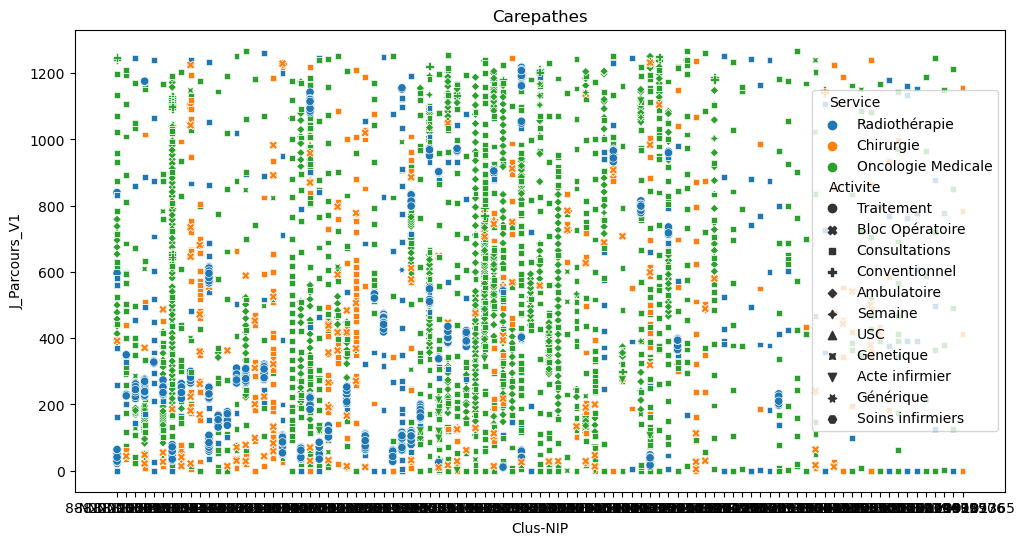

In [ ]:

fig, axs = plt.subplots(1, 1, figsize=(12, 6))

axs.set_title('Carepathes')
sns.scatterplot(data=Parcours_Actes_Filtre[Parcours_Actes_Filtre.Cluster==8], x='Clus-NIP', y='J_Parcours_V1',hue='Service', style='Activite')
#axs.flat[1].set_title('ratings_count boxplot')
#sns.boxplot(data=df, x='ratings_count', ax=axs[1])

plt.show()

### 2nd show the first level of aggregation (Sejour)

In [ ]:
df_sejour.columns

Index(['NIP', 'N_S', 'id_Sequence', 'Type_Sequence', 'J0_V1', 'J0_V2', 'J0_V3',
       'J0_V4', 'J_V1', 'J_V2', 'J_V3', 'J_V4', 'DD_S', 'DF_S',
       'Duree_Sejour_j', 'Id_A_Caracteristique', 'C_UFX', 'C_INX',
       'C_R_NGAP_CCAM_UFH', 'C_Statut', 'C_Code_Equip', 'C_Service',
       'C_Phase_Parcours', 'C_Activite', 'C_Site', 'C_Source'],
      dtype='object')

In [ ]:
df_acte.head()

,NIP,ID_A,N_S,id_Sequence,J0_V1,J0_V2,J0_V3,J0_V4,J_V1,J_V2,...,INX,R_NGAP_CCAM_UFH,Statut,Code_Equip,Service,Phase_Parcours,Activite,Site,Source,Type_Sequence
0,N201204788,501710,N1605690,342,2018-01-15,2019-03-01,2012-07-01,2012-07-01,0,-410,...,6843,DAQL002,E,,Médecine Nucléaire,Diagnostic,Scintigraphie,2,CCAM,INIT_OLD
1,N201507132,561832,N1606070,453,2018-01-15,2018-03-21,2015-07-01,2015-07-01,0,-65,...,10687,QEQK005,E,,Imagerie Médicale,Diagnostic,Senologie,2,CCAM,INIT_OLD
2,N201100317,537166,N1611888,298,2018-01-26,2018-02-16,2011-07-01,2011-07-01,0,-21,...,6828,QEJA001,E,,Autre,Soins,INF,2,CCAM,INIT_OLD
3,N201704012,561718,N1614061,596,2018-01-31,2019-02-13,2017-07-01,2017-07-01,0,-378,...,6853,YYYY600,H,,Imagerie Médicale,Diagnostic,Scanner,2,CCAM,INIT_OLD
4,N201801031,486369,N1621569,675,2018-02-15,2020-11-19,2018-02-15,2020-11-19,0,-1008,...,VEVER,ZZQX069,H,,Anapath,Diagnostic,Labo,2,CCAM,INIT_NEW


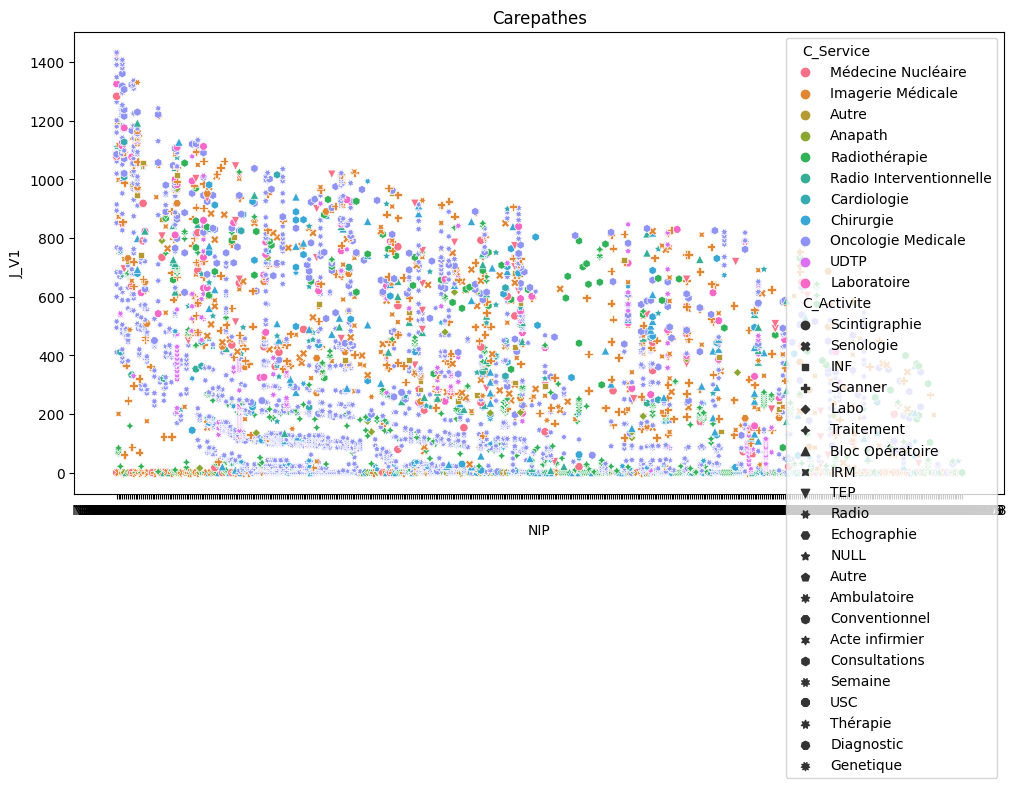

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(12, 6))

axs.set_title('Carepathes')
sns.scatterplot(data=df_sejour, x='NIP', y='J_V1',hue='C_Service', style='C_Activite')
#axs.flat[1].set_title('ratings_count boxplot')
#sns.boxplot(data=df, x='ratings_count', ax=axs[1])

plt.show()

### 3rd show the second level of aggregation (Sequence)

### 4th show the third level of aggregation (Patient)